# Part 1: Manual Implementation of SGD Regressor

# CS6375 - Machine Learning

## Assignment 1

## Team:
Siddhant Suresh Medar - SSM200002 and Adithya Iyer - ASI200000

## Dataset used:

Computer Hardware Data Set

## Data Set Information:

The estimated relative performance values were estimated by the authors using a linear regression method. See their article (pp 308-313) for more details on how the relative performance values were set.


## Attribute Information:

1. vendor name: 30
(adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec,
dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson,
microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry,
sratus, wang)
2. Model Name: many unique symbols
3. MYCT: machine cycle time in nanoseconds (integer)
4. MMIN: minimum main memory in kilobytes (integer)
5. MMAX: maximum main memory in kilobytes (integer)
6. CACH: cache memory in kilobytes (integer)
7. CHMIN: minimum channels in units (integer)
8. CHMAX: maximum channels in units (integer)
9. PRP: published relative performance (integer)
10. ERP: estimated relative performance from the original article (integer)


## Relevant Papers:

Ein-Dor and Feldmesser (CACM 4/87, pp 308-317)

Kibler,D. & Aha,D. (1988). Instance-Based Prediction of Real-Valued Attributes. In Proceedings of the CSCSI (Canadian AI) Conference.

## Target Variable: 

ERP = estimated relative performance from the original article (integer)

# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, SGDRegressor
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import sys
import io
%matplotlib inline

# Load the dataset

In [2]:
columns = ['VENDOR NAME','MODEL NAME','MYCT','MMIN','MMAX','CACH','CHMIN',
           'CHMAX','PRP','ERP']
df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data'
    , names = columns)

# Peform Exploratory Data Analysis

In [3]:
#peek through the data
df.head()

,VENDOR NAME,MODEL NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


## Pre-processing the data

In [4]:
#check for NULL values
print (df.isnull().sum())

VENDOR NAME    0
MODEL NAME     0
MYCT           0
MMIN           0
MMAX           0
CACH           0
CHMIN          0
CHMAX          0
PRP            0
ERP            0
dtype: int64


In [5]:
#remove missing values - no missing values were found
df.dropna( inplace = True )

In [6]:
#drop duplicate items - no duplicate items were found
df.drop_duplicates()

,VENDOR NAME,MODEL NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...,...
204,sperry,80/8,124,1000,8000,0,1,8,42,37
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
206,sratus,32,125,2000,8000,0,2,14,52,41
207,wang,vs-100,480,512,8000,32,0,0,67,47


In [7]:
#information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   VENDOR NAME  209 non-null    object
 1   MODEL NAME   209 non-null    object
 2   MYCT         209 non-null    int64 
 3   MMIN         209 non-null    int64 
 4   MMAX         209 non-null    int64 
 5   CACH         209 non-null    int64 
 6   CHMIN        209 non-null    int64 
 7   CHMAX        209 non-null    int64 
 8   PRP          209 non-null    int64 
 9   ERP          209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 18.0+ KB


In [8]:
#explore data
df.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


In [9]:
#explore target variable
df["ERP"].describe()

count     209.000000
mean       99.330144
std       154.757102
min        15.000000
25%        28.000000
50%        45.000000
75%       101.000000
max      1238.000000
Name: ERP, dtype: float64

## Feature Engineering

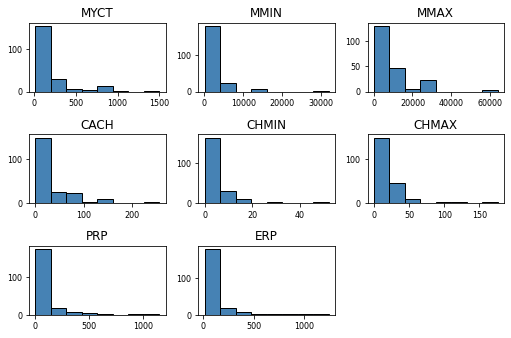

In [10]:
#histogram plots for each column
df.hist(bins=8, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [11]:
#calculate correlation between the attributes
correlations = df.corr()
print(correlations)

           MYCT      MMIN      MMAX  ...     CHMAX       PRP       ERP
MYCT   1.000000 -0.335642 -0.378561  ... -0.250502 -0.307099 -0.288396
MMIN  -0.335642  1.000000  0.758157  ...  0.266907  0.794931  0.819292
MMAX  -0.378561  0.758157  1.000000  ...  0.527246  0.863004  0.901202
CACH  -0.321000  0.534729  0.537990  ...  0.487846  0.662641  0.648620
CHMIN -0.301090  0.517189  0.560513  ...  0.548281  0.608903  0.610580
CHMAX -0.250502  0.266907  0.527246  ...  1.000000  0.605209  0.592156
PRP   -0.307099  0.794931  0.863004  ...  0.605209  1.000000  0.966472
ERP   -0.288396  0.819292  0.901202  ...  0.592156  0.966472  1.000000

[8 rows x 8 columns]


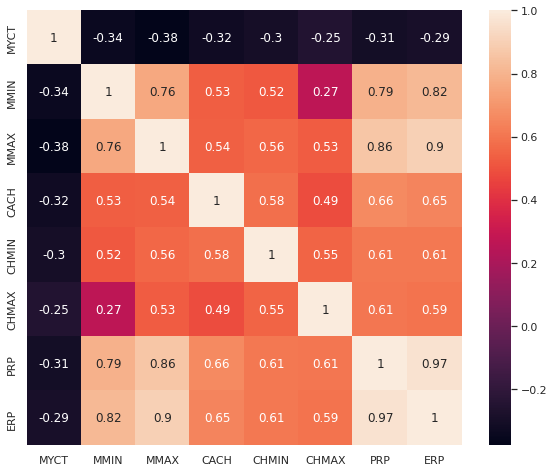

In [12]:
#plot heatmap to visualize the correlation
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(correlations, annot=True,square=True)
plt.show()

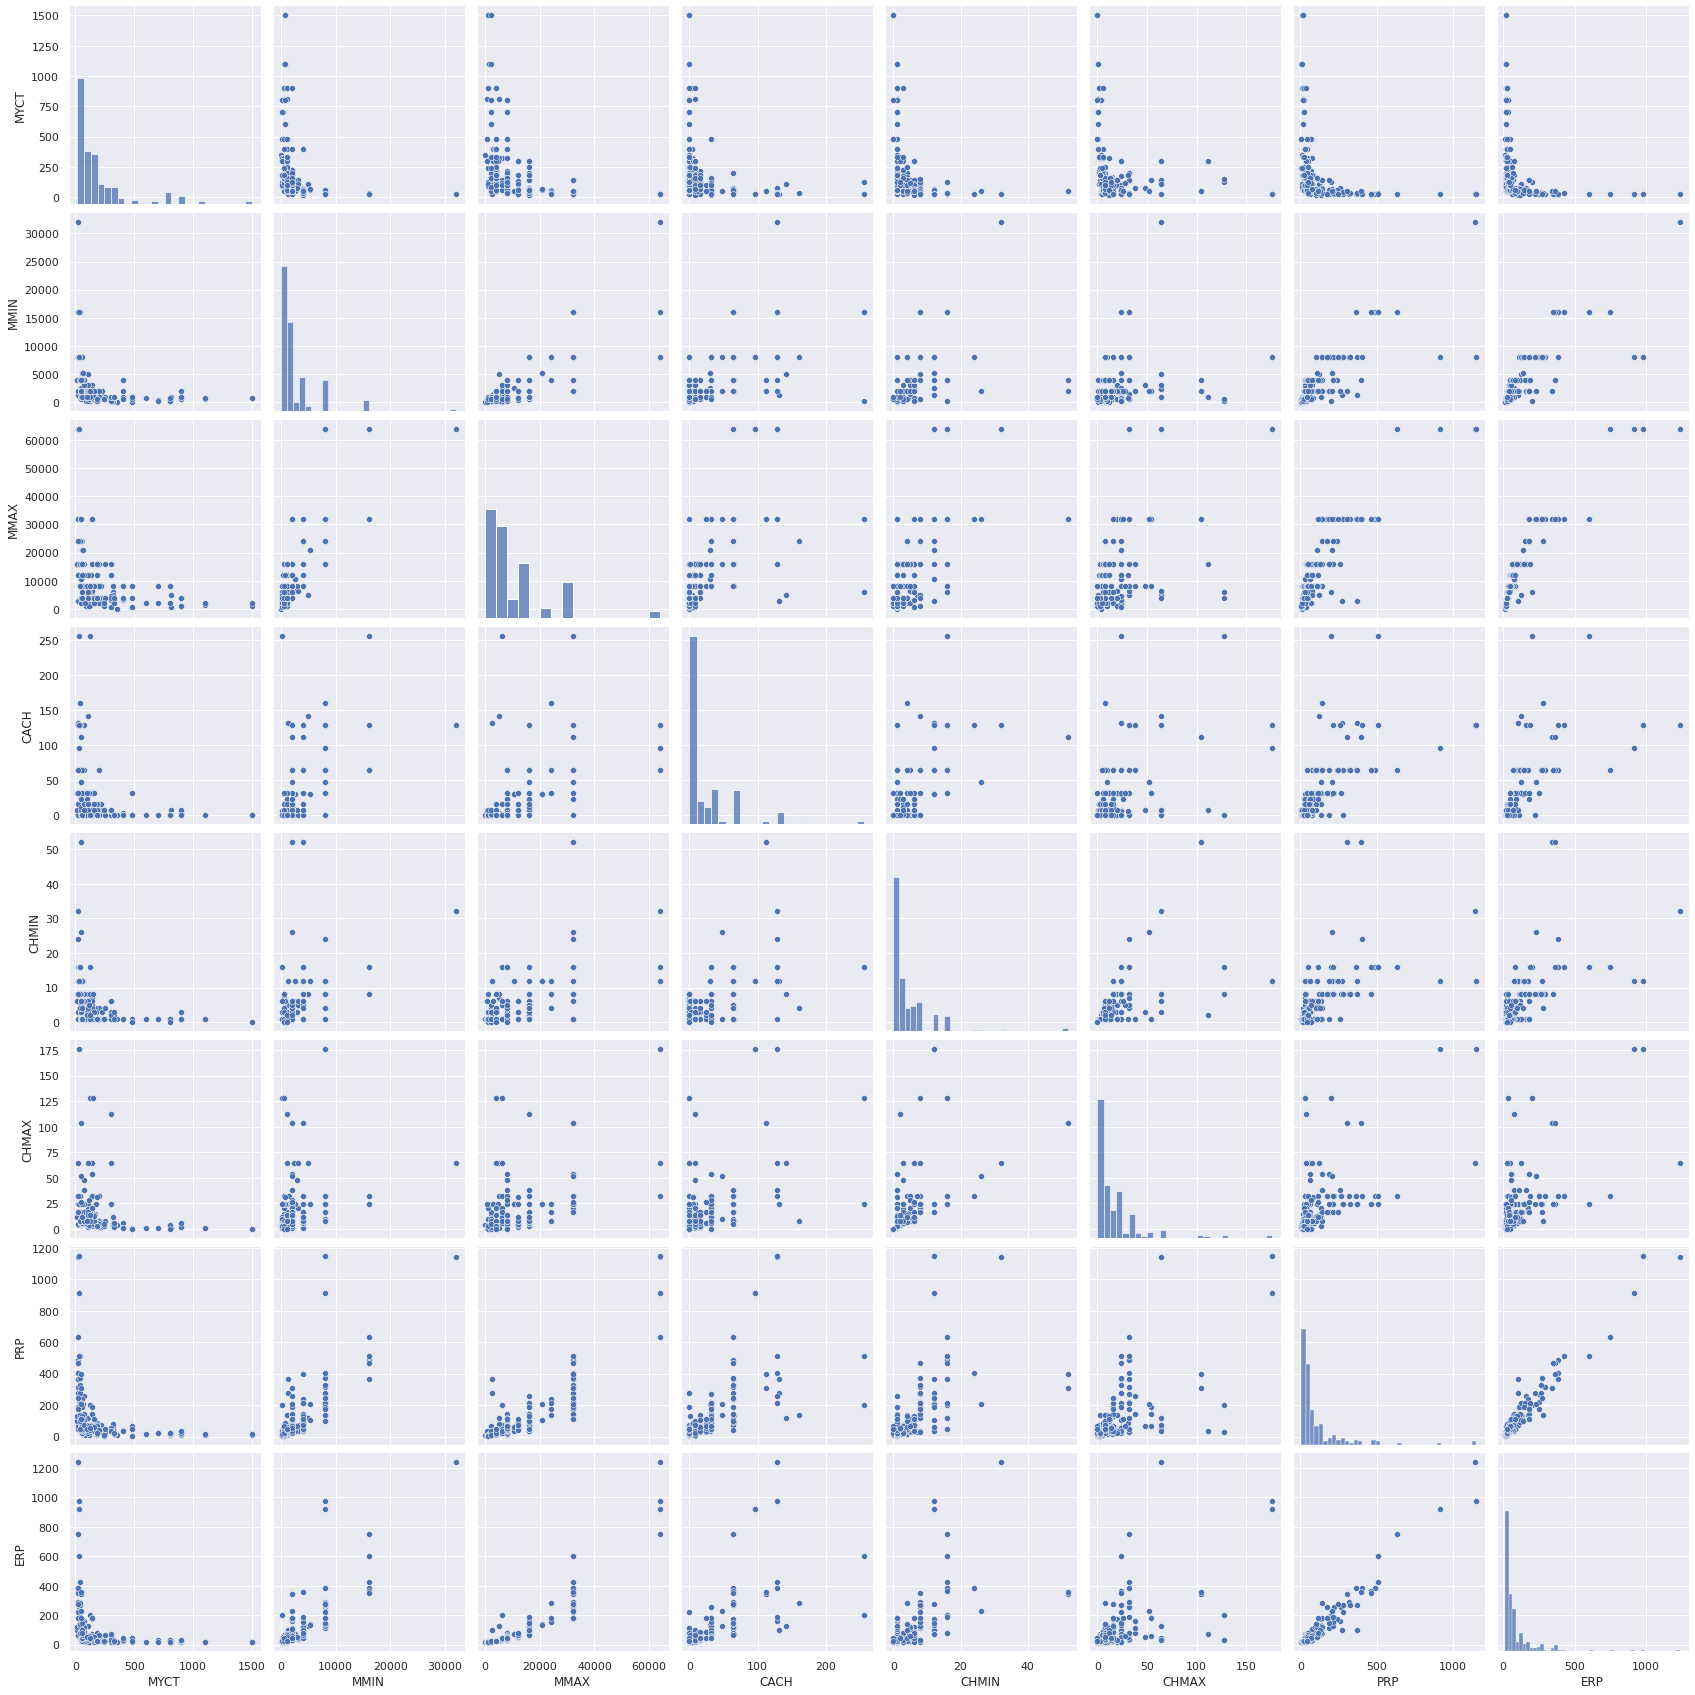

In [13]:
#pairplot to check the pairwise relationships in the dataset
sns.set()
sns.pairplot(df, size=3)
plt.show()

### Conclusion: We observed during exploratory analysis that the first two attributes - Vendor name and Model Name does not contribute to the end result. 
### Decision : Drop two attributes - Vendor name and Model Name

# PART 1 - Impelementing SGD regressor manually

## Splitting the data into independent and dependent variables - X and y

In [14]:
data = df.iloc[:,2:]

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [15]:
# Splitting the data into training and testing samples 
#Using 80/20 split for training and testing respectively
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, random_state = 42, shuffle = True)

In [16]:
#shape of X_Train and X_Test
X_train.shape, X_test.shape

((167, 7), (42, 7))

In [17]:
#shape of Y_Train and Y_Test
y_train.shape, y_test.shape

((167,), (42,))

In [18]:
#standardize features by removing the mean and scaling to unit variance
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [19]:
#apply the calculations performed earlier in fit() 
#to every data point in feature using transform()
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [20]:
class ManualSGD:
    def __init__(self,learning_rate=0.001,max_iterations=500,threshold=None): 
        #constructor
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.threshold = threshold
     
    def predict(self,X): 
        #function to predict the values using newly created model
        X=np.insert(X.T,0,np.ones(X.shape[0]),axis=0)
        return np.dot(self.weights,X)

    def Rsquared(self,X,Y): 
        #function to calculate r2 score
        return 1-(((Y - self.predict(X))**2).sum()/((Y - Y.mean())**2).sum())

    def loss_function(self,x,y,category='mse'):
        if category == 'mse':
            loss=np.sum(np.square(x.reshape(-1, 1) - y.reshape(-1, 1)))
            /(2*x.shape[0])
        return np.round(loss,3)
    
    def fit(self,X,y): 
        #function to fit the data on the model
        self.losses=[] #list to track the losses
        self.X=X
        self.y=y
        #initialize weights and biases
        self.weights = np.random.rand(self.X.shape[1]+1).reshape(1,-1)               
        #pad with ones for bias
        self.feature_vector = np.insert(self.X.T, 0,
                                        np.ones(self.X.shape[0]), axis=0)   
        dw=0 
        
        while self.max_iterations>=0:
            self.hyp = np.dot(self.weights,self.feature_vector)
            self.losses.append(self.loss_function(self.hyp,y))
            # @ is matrix multiplication
            dw = (self.feature_vector@(self.hyp-self.y).T) 
            dw /= self.X.shape[0]        #average it
            self.weights -= (self.learning_rate*dw.reshape(1,-1)) 
            #update weights
            self.max_iterations -= 1 #decrement iterations count by 1

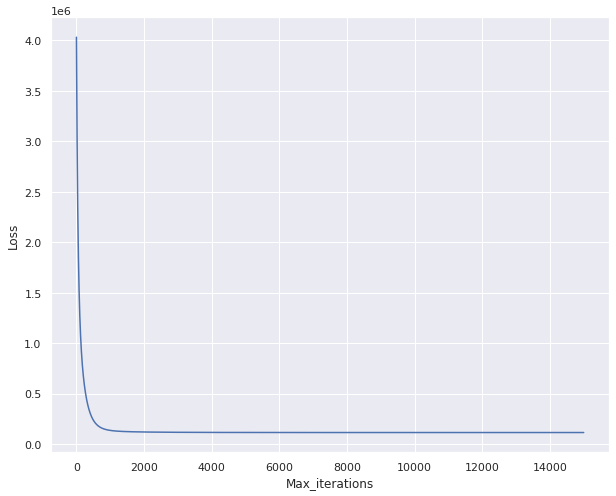

In [21]:
#Optimum LR and Itrs
lr, itrs = 0.003, 15000

#create object of class
model = ManualSGD(learning_rate=lr,max_iterations=itrs)

#fit the training data on the model
model.fit(X_train_sc,np.array(y_train))

#predict
y_pred=model.predict(X_test_sc)

loss=list(model.losses)

#visualize loss
plt.plot(loss)
plt.xlabel("Max_iterations")
plt.ylabel("Loss")
plt.show()

In [22]:
r2 = model.Rsquared(X_train_sc,np.array(y_train))
mae = mean_absolute_error(y_test, y_pred[0])
rmse = mean_squared_error(y_test, y_pred[0], squared=False)
evs = explained_variance_score(y_test, y_pred[0])

In [23]:
weights = list(model.weights)
print("Weights: ",weights)

Weights:  [array([92.22754491,  8.61135461, 12.15708748, 44.29981758, 13.39012229,
       -1.37289294,  5.42281678, 66.24193932])]


In [24]:
print()
print("For LR: "+str(lr)+", Iterations= "+str(itrs))
print("======================================")
print("R2 Score: ", r2)
print("Mean absolute error: ", mae)
print("Root Mean squared error: ", rmse)
print("Explained Variance Score: ", evs)


For LR: 0.003, Iterations= 15000
R2 Score:  0.9571726139921094
Mean absolute error:  25.526649239429617
Root Mean squared error:  54.87979243324654
Explained Variance Score:  0.9463933128634727


In [25]:
file = open("Manual_SGD_log.txt","a")
file.write("LR = " + str(lr) + ", max_iterations = " + str(itrs) + 
           ", R^2 = "+str(r2) + ", MAE = "+str(mae) + ", RMSE = " + str(rmse) +
           ", Explained-Variance = " + str(evs) + " \n")
file.close()
print("Wrote to file sucessfully.")

Wrote to file sucessfully.


## Observation:
## For a learning rate = 0.003 and n_iterations = 15000, we get a r2 score of 95.71%
## Now increasing iterations to check if it increases the accuracy further

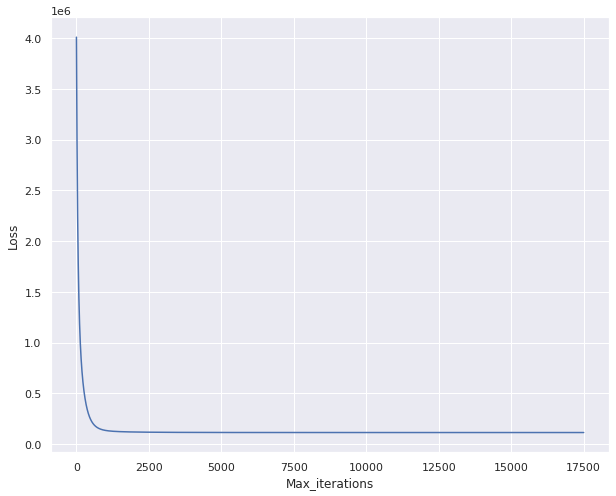


For LR: 0.003, Iterations= 17500
R2 Score:  0.9571727799167745
Mean absolute error:  25.52037231231766
Root Mean squared error:  54.85932675325127
Explained Variance Score:  0.9464330519974609
Wrote to file sucessfully.


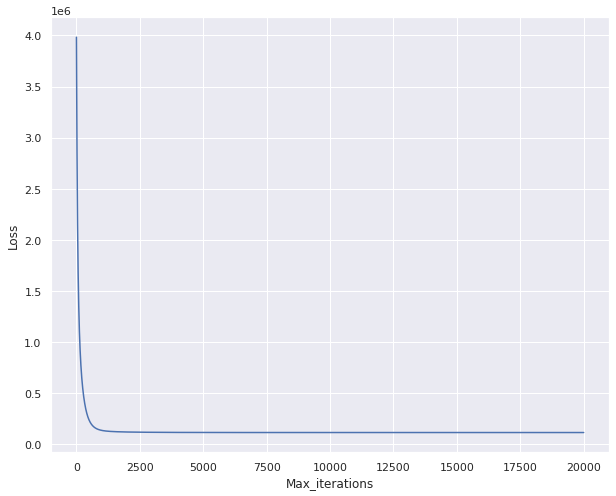


For LR: 0.003, Iterations= 20000
R2 Score:  0.957172808760194
Mean absolute error:  25.51773619243657
Root Mean squared error:  54.850767011135126
Explained Variance Score:  0.9464496877979258
Wrote to file sucessfully.


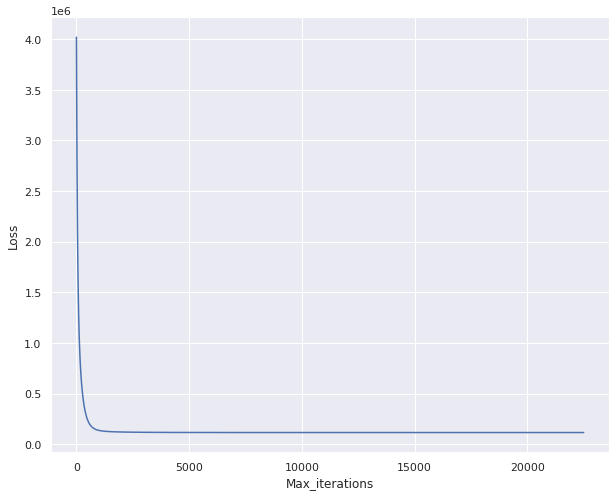


For LR: 0.003, Iterations= 22500
R2 Score:  0.957172814091838
Mean absolute error:  25.51658697346695
Root Mean squared error:  54.84704422786904
Explained Variance Score:  0.9464569275093573
Wrote to file sucessfully.


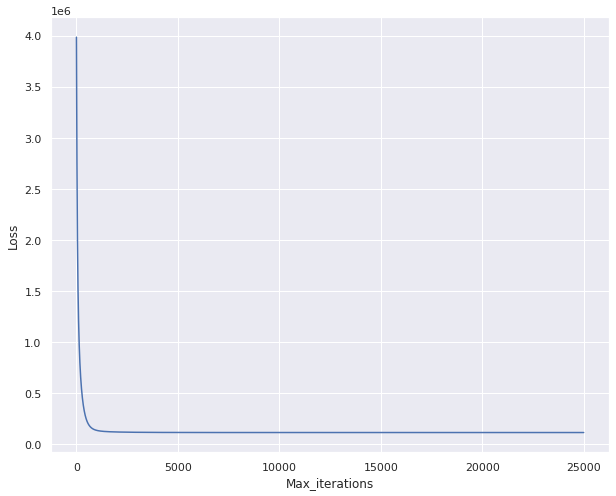


For LR: 0.003, Iterations= 25000
R2 Score:  0.9571728150608146
Mean absolute error:  25.51609973310397
Root Mean squared error:  54.845467757556975
Explained Variance Score:  0.9464599943109608
Wrote to file sucessfully.


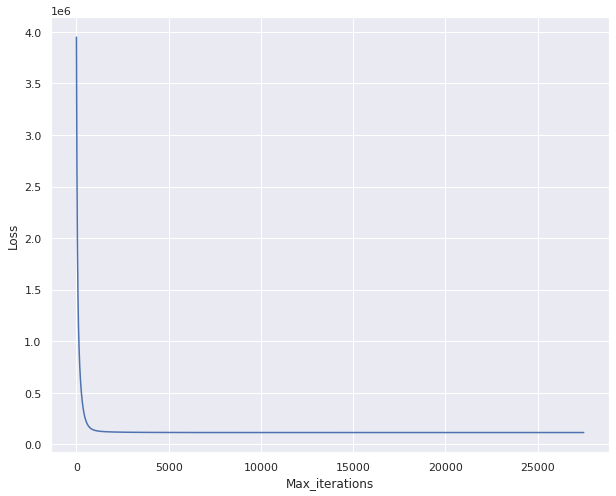


For LR: 0.003, Iterations= 27500
R2 Score:  0.9571728152486338
Mean absolute error:  25.5158821444334
Root Mean squared error:  54.84476423389084
Explained Variance Score:  0.9464613632050234
Wrote to file sucessfully.


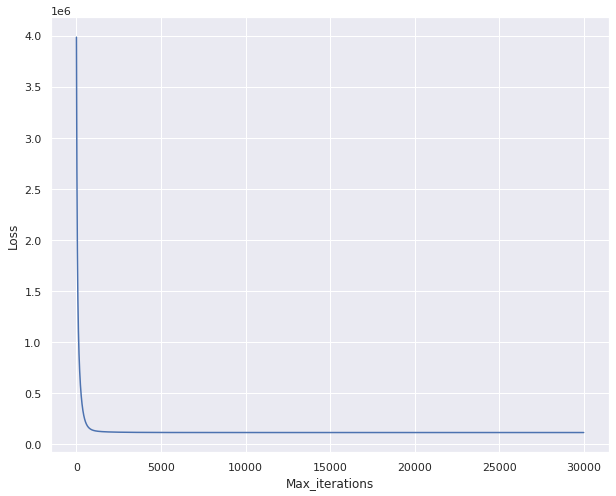


For LR: 0.003, Iterations= 30000
R2 Score:  0.9571728152832856
Mean absolute error:  25.51578865526772
Root Mean squared error:  54.84446207818008
Explained Variance Score:  0.9464619512050638
Wrote to file sucessfully.


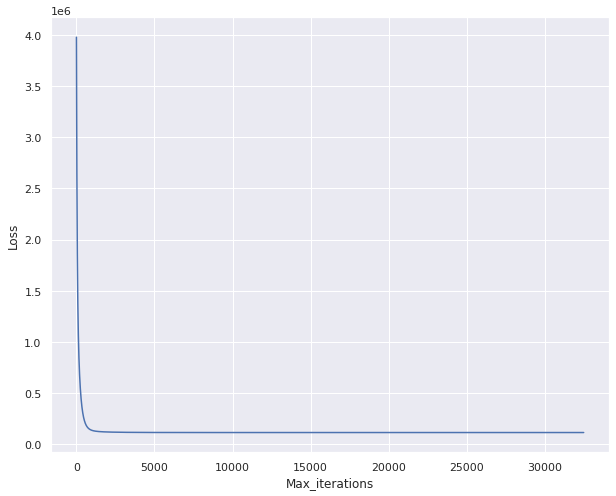


For LR: 0.003, Iterations= 32500
R2 Score:  0.9571728152897906
Mean absolute error:  25.515747715431345
Root Mean squared error:  54.84432978683186
Explained Variance Score:  0.9464622086625277
Wrote to file sucessfully.


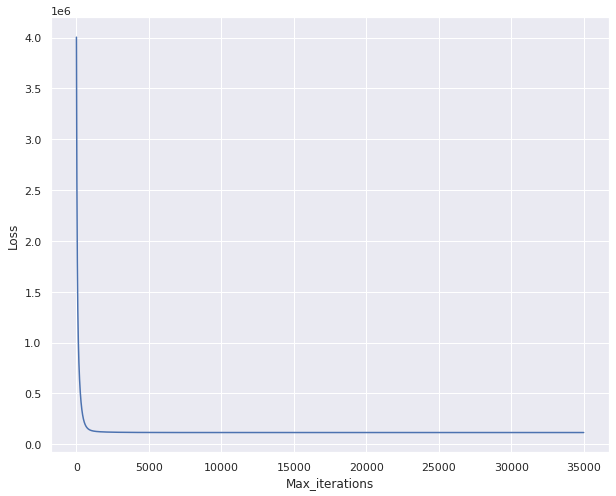


For LR: 0.003, Iterations= 35000
R2 Score:  0.9571728152909479
Mean absolute error:  25.515730621148805
Root Mean squared error:  54.844274554797856
Explained Variance Score:  0.9464623161555452
Wrote to file sucessfully.


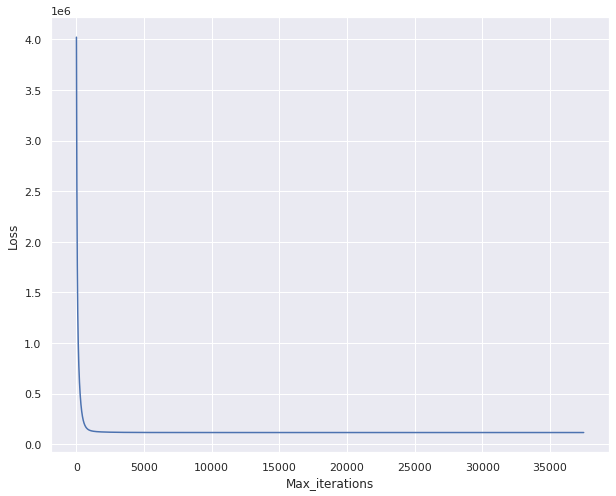


For LR: 0.003, Iterations= 37500
R2 Score:  0.9571728152911645
Mean absolute error:  25.515723221121945
Root Mean squared error:  54.84425064668902
Explained Variance Score:  0.9464623626867467
Wrote to file sucessfully.


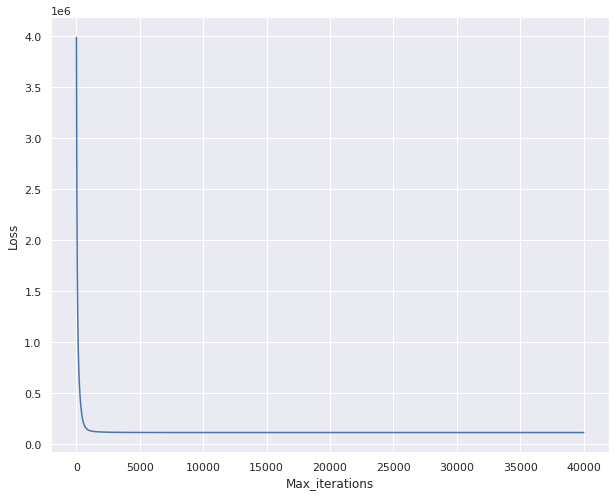


For LR: 0.003, Iterations= 40000
R2 Score:  0.9571728152912051
Mean absolute error:  25.51571999010045
Root Mean squared error:  54.844240208227276
Explained Variance Score:  0.9464623830028744
Wrote to file sucessfully.


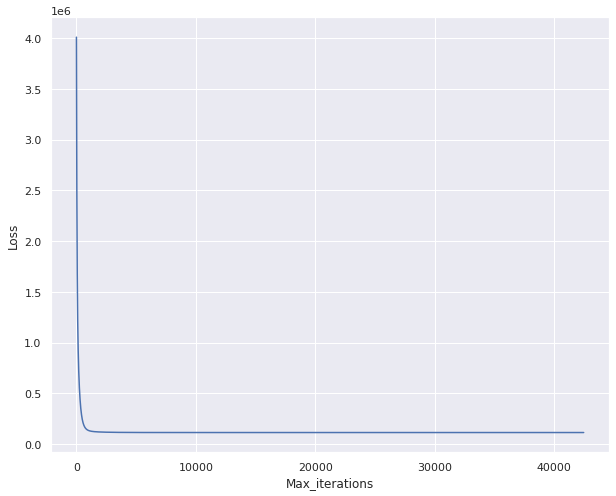


For LR: 0.003, Iterations= 42500
R2 Score:  0.9571728152912126
Mean absolute error:  25.5157186218835
Root Mean squared error:  54.84423578801216
Explained Variance Score:  0.9464623916058913
Wrote to file sucessfully.


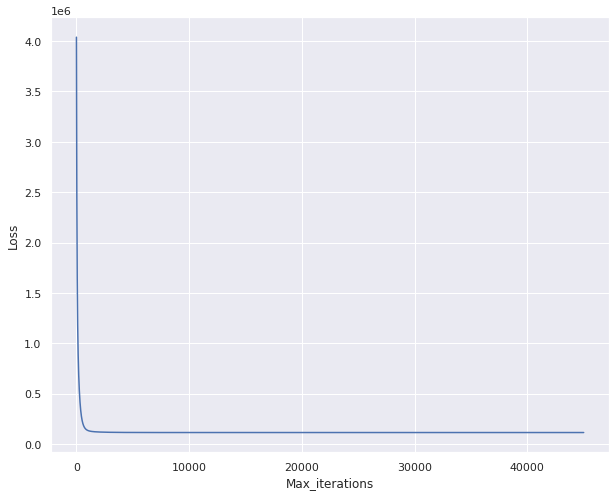


For LR: 0.003, Iterations= 45000
R2 Score:  0.9571728152912139
Mean absolute error:  25.51571804087901
Root Mean squared error:  54.844233911015074
Explained Variance Score:  0.9464623952590836
Wrote to file sucessfully.


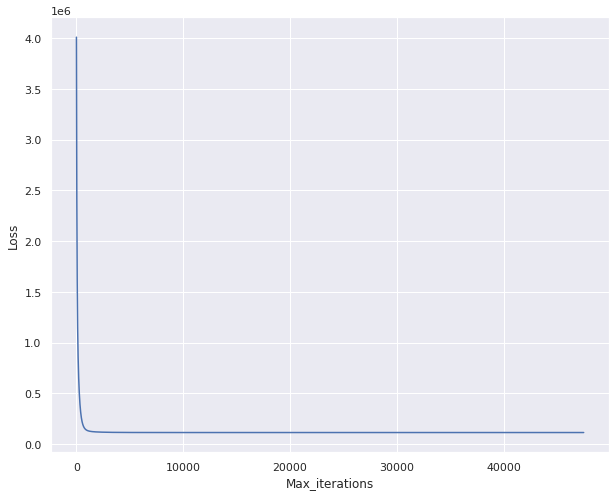


For LR: 0.003, Iterations= 47500
R2 Score:  0.9571728152912141
Mean absolute error:  25.51571777851117
Root Mean squared error:  54.84423306341335
Explained Variance Score:  0.9464623969087715
Wrote to file sucessfully.


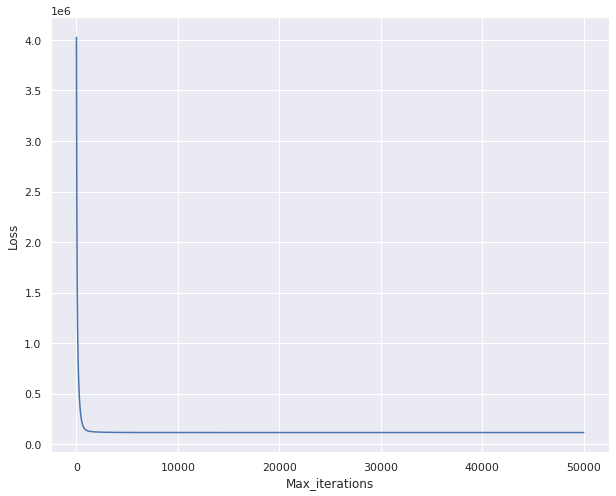


For LR: 0.003, Iterations= 50000
R2 Score:  0.9571728152912142
Mean absolute error:  25.51571767046275
Root Mean squared error:  54.844232714354575
Explained Variance Score:  0.9464623975881455
Wrote to file sucessfully.


In [26]:
lr,r2_lst = 0.003,[]

itrs = 17500
while itrs<=50000:
    model = ManualSGD(learning_rate=lr,max_iterations=itrs)

    #fit the training data on the model
    model.fit(X_train_sc,np.array(y_train))

    #predict
    y_pred=model.predict(X_test_sc)

    loss=list(model.losses)

    #visualize loss
    plt.plot(loss)
    plt.xlabel("Max_iterations")
    plt.ylabel("Loss")
    plt.show()
    
    r2 = model.Rsquared(X_train_sc,np.array(y_train))
    mae = mean_absolute_error(y_test, y_pred[0])
    rmse = mean_squared_error(y_test, y_pred[0], squared=False)
    evs = explained_variance_score(y_test, y_pred[0])
    
    print("\nFor LR: "+str(lr)+", Iterations= "+str(itrs))
    print("======================================")
    print("R2 Score: ", r2)
    print("Mean absolute error: ", mae)
    print("Root Mean squared error: ", rmse)
    print("Explained Variance Score: ", evs)
    
    file = open("Manual_SGD_log.txt","a")
    file.write("LR = " + str(lr) + ", max_iterations = " + str(itrs) + 
               ", R^2 = " + str(r2) + ", MAE = " + str(mae) + ", RMSE = " + 
               str(rmse) + ", Explained-Variance = " + str(evs) + " \n")
    file.close()
    print("Wrote to file sucessfully.")

    r2_lst.append(np.around(r2,7))
    itrs+=2500

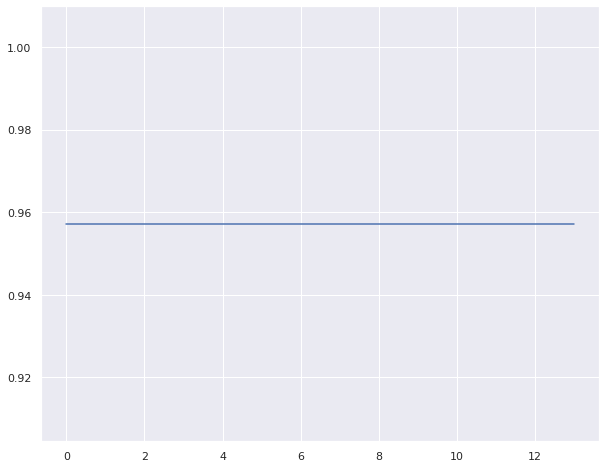

In [27]:
plt.plot(r2_lst)

## Conclusion:
## From the above plot, it can observed that increasing n_iterations above 15000 does not improve r2_score
#The increase is of the order of 10^-7, which is very insignificant for so many iterations

## Now we can try altering learning_rate

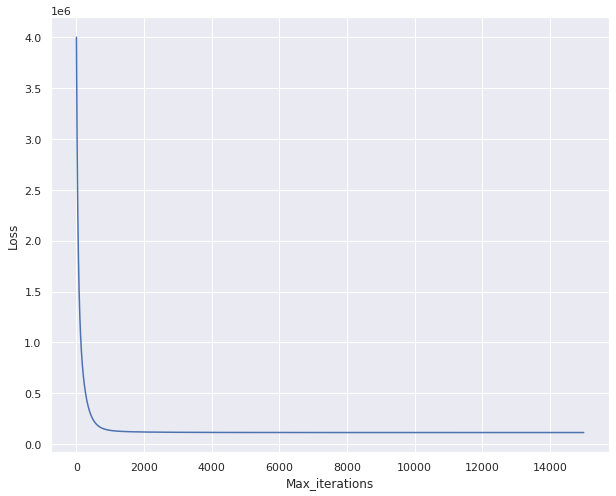


For LR: 0.003, Iterations= 52500
R2 Score:  0.9571726216743162
Mean absolute error:  25.526426996845554
Root Mean squared error:  54.87907491997556
Explained Variance Score:  0.9463947117469326
Wrote to file sucessfully.


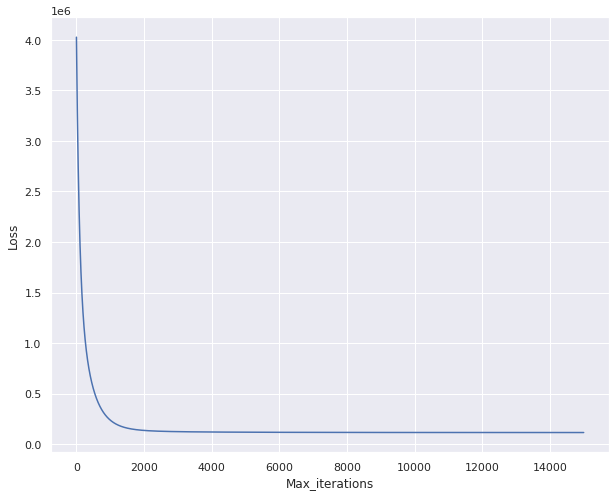


For LR: 0.0015, Iterations= 52500
R2 Score:  0.9571405656048058
Mean absolute error:  25.629076926462837
Root Mean squared error:  55.23074618035433
Explained Variance Score:  0.9457174268021795
Wrote to file sucessfully.


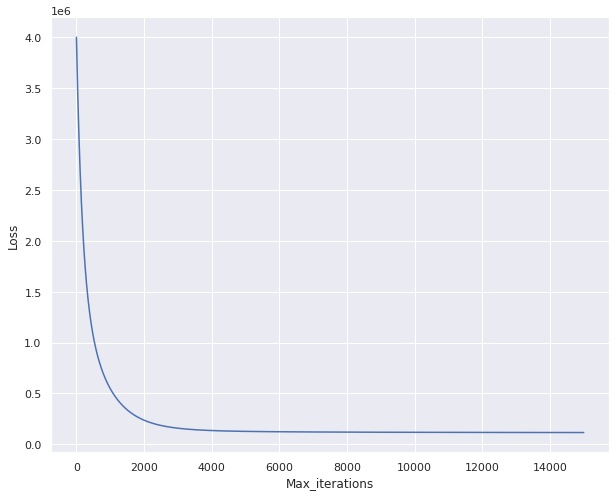


For LR: 0.00075, Iterations= 52500
R2 Score:  0.9567020917804513
Mean absolute error:  25.75930566780692
Root Mean squared error:  55.900820262828724
Explained Variance Score:  0.9444579482298912
Wrote to file sucessfully.


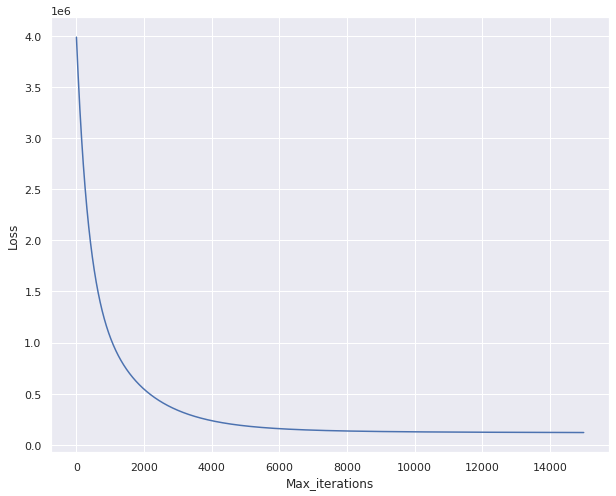


For LR: 0.000375, Iterations= 52500
R2 Score:  0.9549677341191553
Mean absolute error:  25.897145650679754
Root Mean squared error:  56.662044289847884
Explained Variance Score:  0.9430712074590496
Wrote to file sucessfully.


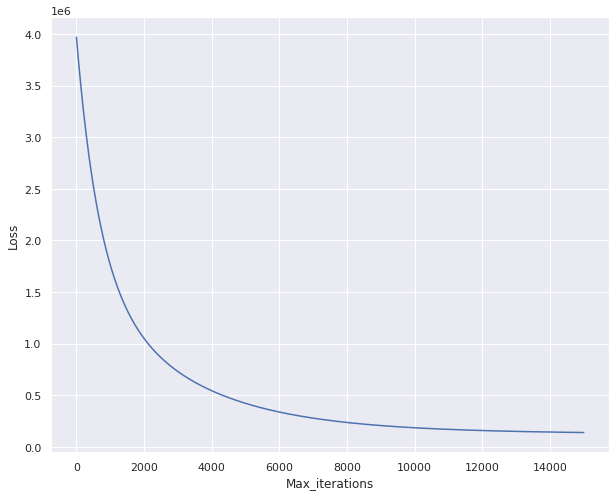


For LR: 0.0001875, Iterations= 52500
R2 Score:  0.9480591086311615
Mean absolute error:  27.518134885629756
Root Mean squared error:  60.72328322993885
Explained Variance Score:  0.9367437165109976
Wrote to file sucessfully.


In [28]:
#try combination of lr by keeping n_iterations constant i.e 15000
lr = 0.003
r2_lst = []

while lr >= 0.0001:
    model = ManualSGD(learning_rate=lr,max_iterations=15000)

    #fit the training data on the model
    model.fit(X_train_sc,np.array(y_train))

    #predict
    y_pred=model.predict(X_test_sc)

    loss=list(model.losses)

    #visualize loss
    plt.plot(loss)
    plt.xlabel("Max_iterations")
    plt.ylabel("Loss")
    plt.show()
    
    r2 = model.Rsquared(X_train_sc,np.array(y_train))
    mae = mean_absolute_error(y_test, y_pred[0])
    rmse = mean_squared_error(y_test, y_pred[0], squared=False)
    evs = explained_variance_score(y_test, y_pred[0])
    
    print("\nFor LR: "+str(lr)+", Iterations= "+str(itrs))
    print("======================================")
    print("R2 Score: ", r2)
    print("Mean absolute error: ", mae)
    print("Root Mean squared error: ", rmse)
    print("Explained Variance Score: ", evs)
    
    file = open("Manual_SGD_log.txt","a")
    file.write("LR = " + str(lr) + ", max_iterations = " + str(itrs) + 
               ", R^2 = " + str(r2) + ", MAE = " + str(mae) + ", RMSE = " + 
               str(rmse) + ", Explained-Variance = " + str(evs) + " \n")
    file.close()
    print("Wrote to file sucessfully.")

    r2_lst.append(np.around(r2,2))
    lr/=2

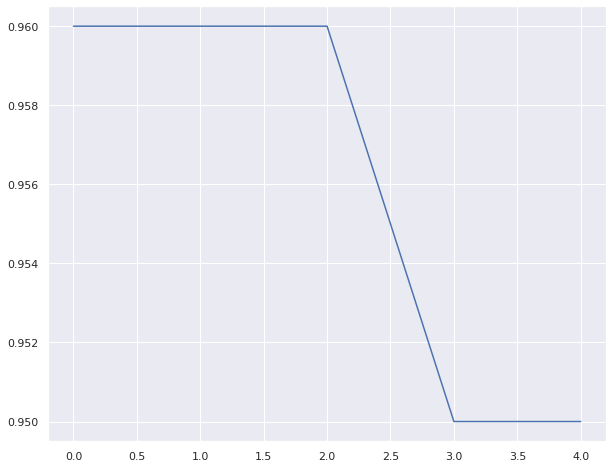

In [29]:
plt.plot(r2_lst)

## The accuracy falls when learning rate is altered while keeping the n_iterations same

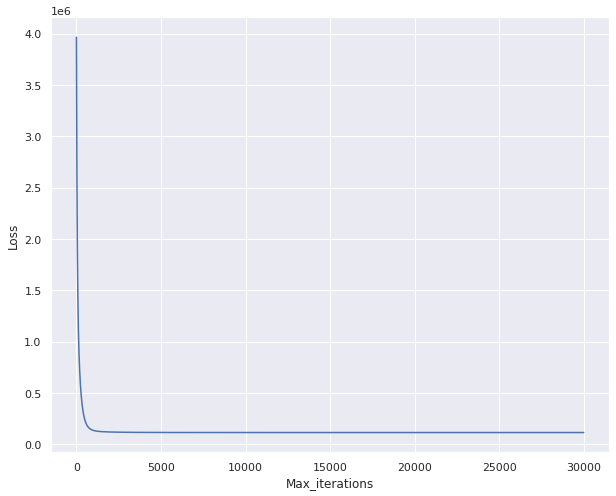


For LR: 0.003, Iterations= 52500
R2 Score:  0.957172815283322
Mean absolute error:  25.515788493252806
Root Mean squared error:  54.84446155383323
Explained Variance Score:  0.9464619522249244
Wrote to file sucessfully.


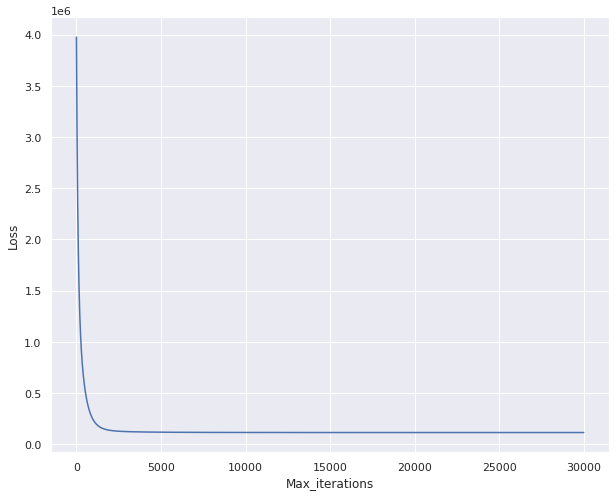


For LR: 0.0015, Iterations= 52500
R2 Score:  0.9571726168483918
Mean absolute error:  25.526572660020747
Root Mean squared error:  54.87954240570421
Explained Variance Score:  0.9463937983172975
Wrote to file sucessfully.


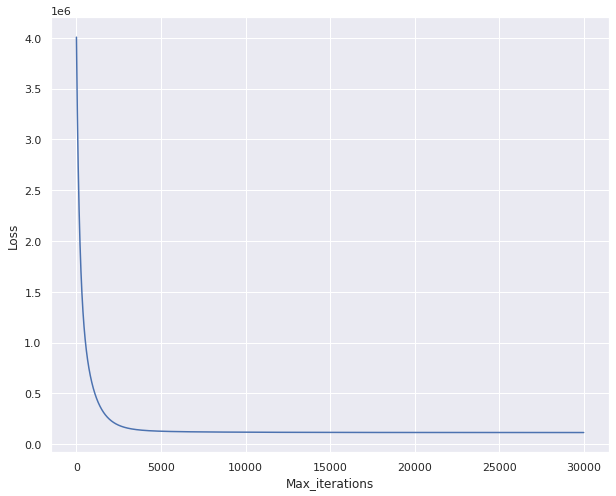


For LR: 0.00075, Iterations= 52500
R2 Score:  0.957139743491757
Mean absolute error:  25.62997047277682
Root Mean squared error:  55.234194838556036
Explained Variance Score:  0.9457109680083321
Wrote to file sucessfully.


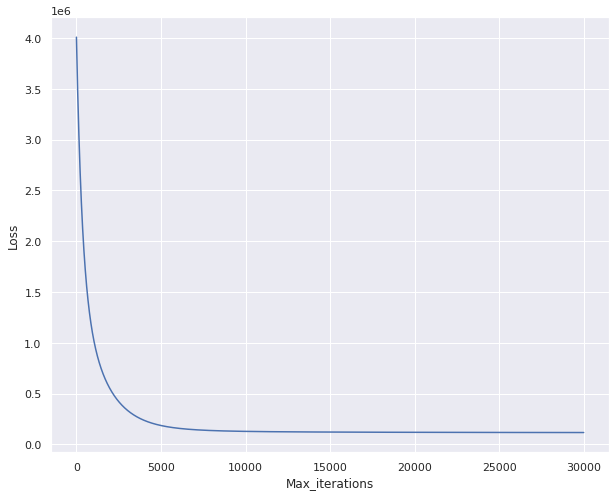


For LR: 0.000375, Iterations= 52500
R2 Score:  0.9567126289489319
Mean absolute error:  25.7473564715255
Root Mean squared error:  55.86300771982175
Explained Variance Score:  0.944534172478918
Wrote to file sucessfully.


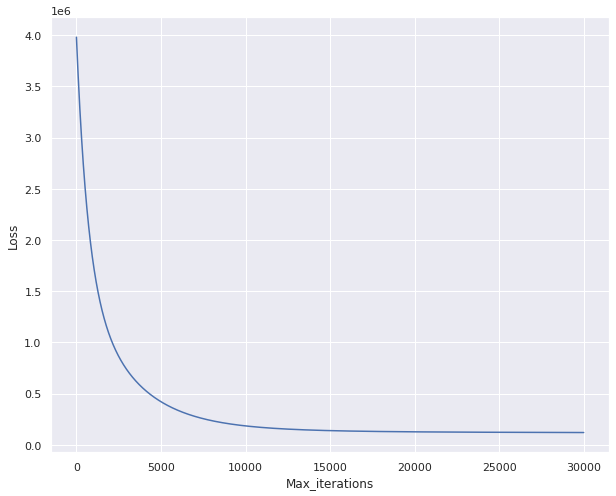


For LR: 0.0001875, Iterations= 52500
R2 Score:  0.9549991121300001
Mean absolute error:  25.87462331295083
Root Mean squared error:  56.63143046728613
Explained Variance Score:  0.9431276147057309
Wrote to file sucessfully.


In [30]:
lr = 0.003
r2_lst = []

while lr >= 0.0001:
    model = ManualSGD(learning_rate=lr,max_iterations=30000)

    #fit the training data on the model
    model.fit(X_train_sc,np.array(y_train))

    #predict
    y_pred=model.predict(X_test_sc)

    loss=list(model.losses)

    #visualize loss
    plt.plot(loss)
    plt.xlabel("Max_iterations")
    plt.ylabel("Loss")
    plt.show()
    
    r2 = model.Rsquared(X_train_sc,np.array(y_train))
    mae = mean_absolute_error(y_test, y_pred[0])
    rmse = mean_squared_error(y_test, y_pred[0], squared=False)
    evs = explained_variance_score(y_test, y_pred[0])
    
    print("\nFor LR: "+str(lr)+", Iterations= "+str(itrs))
    print("======================================")
    print("R2 Score: ", r2)
    print("Mean absolute error: ", mae)
    print("Root Mean squared error: ", rmse)
    print("Explained Variance Score: ", evs)
    
    file = open("Manual_SGD_log.txt","a")
    file.write("LR = " + str(lr) + ", max_iterations = " + str(itrs) + 
               ", R^2 = " + str(r2) + ", MAE = " + str(mae) + ", RMSE = " + 
               str(rmse) + ", Explained-Variance = " + str(evs) + " \n")
    file.close()
    print("Wrote to file sucessfully.")

    r2_lst.append(r2)
    lr/=2

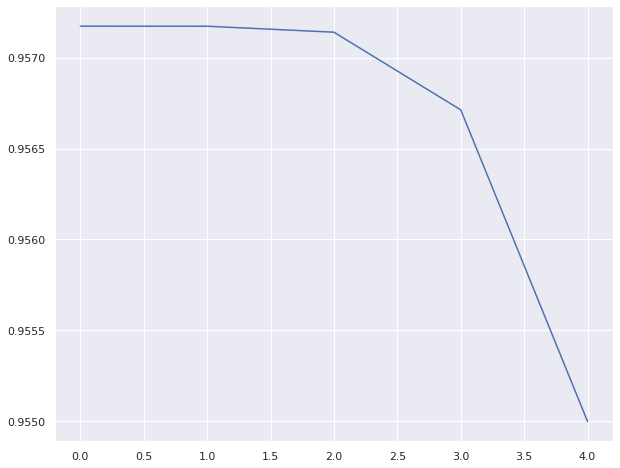

In [31]:
plt.plot(r2_lst)

## From the above plot we can observe that increasing iterations also doesn't help much.

# PART 2 - Impelementing SGD regressor using Scikit-learn library

In [32]:
#use GridSearchCV to loop through predefined hyperparameters and 
#    fit your estimator (model) on your training set to find 
#    the best parameters from the listed hyperparameters

p={'learning_rate': ['constant'], 'eta0': [0.001, 0.01, 0.02, 0.05, 0.08, 0.1],
   'max_iter':[500, 1000, 2000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 
               35000, 40000, 45000, 50000]}

sgd=SGDRegressor()

model=GridSearchCV(sgd,param_grid=p)

In [33]:
#fit the data on the model created
model.fit(X_train_sc,y_train)

GridSearchCV(estimator=SGDRegressor(),
             param_grid={'eta0': [0.001, 0.01, 0.02, 0.05, 0.08, 0.1],
                         'learning_rate': ['constant'],
                         'max_iter': [500, 1000, 2000, 5000, 7000, 10000, 15000,
                                      20000, 25000, 30000, 35000, 40000, 45000,
                                      50000]})

In [34]:
#print best estimators found by the model
model.best_estimator_

SGDRegressor(eta0=0.02, learning_rate='constant', max_iter=30000)

In [35]:
#print best parameters found by the model
print(model.best_params_)

{'eta0': 0.02, 'learning_rate': 'constant', 'max_iter': 30000}


In [36]:
#print best score found by the model
print(model.best_score_)

0.9400688104995936


In [37]:
#predict using the model
y_pred=model.predict(X_test_sc)

In [38]:
#calculate metrics
r2 = model.score(X_train_sc,y_train)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
evs = explained_variance_score(y_test, y_pred)

print("R2 Score: ", r2)
print("Mean absolute error: ", mae)
print("Root Mean squared error: ", rmse)
print("Explained Variance Score: ", evs)

R2 Score:  0.9426297591728554
Mean absolute error:  30.693156077522872
Root Mean squared error:  66.38940030040736
Explained Variance Score:  0.9225820701019357


## Conclusion: We obtained a r2 score of 95.16% using scikit library which is less than that of our custom SGD regressor's score using GridSearchCV

## Comparing model performance with same set of parameters as that of our custom model

In [39]:
#Function to display loss curve during each iteration
class DisplayLossCurve(object):
  def __init__(self, print_loss=False):
    self.print_loss = print_loss

  """Make sure the model verbose is set to 1"""
  def __enter__(self):
    self.old_stdout = sys.stdout
    sys.stdout = self.mystdout = io.StringIO()
  
  def __exit__(self, *args, **kwargs):
    sys.stdout = self.old_stdout
    loss_history = self.mystdout.getvalue()
    loss_list = []
    for line in loss_history.split('\n'):
      if(len(line.split("loss: ")) == 1):
        continue
      loss_list.append(float(line.split("loss: ")[-1]))
    plt.figure()
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    if self.print_loss:
      print("=============== Loss Array ===============")
      print(np.array(loss_list))
      
    return True

In [40]:
lr, itrs = 0.003, 15000
model=SGDRegressor(learning_rate='constant', eta0=lr, max_iter=itrs, verbose=1)

=============== Loss Array ===============
[6074.141682 1812.777835  943.7183    657.620291  516.093557  457.495796
  408.347118  426.823423  417.63173   399.898885  389.158239  396.61693
  391.665313  381.198069  389.29442   388.180112  380.120248  391.028287
  386.078642  379.787734  382.843997  378.615876  379.319834  382.701272
  375.815245  380.435192  370.899655  382.11838   381.610133  379.115317
  381.152597  367.206297  377.523637  375.750139  375.159381  371.724194
  375.716747]

LR: 0.003 Iterations= 15000
R2 Score:  0.9565421203737108
Mean absolute error:  25.47748191911172
Root Mean squared error:  51.82665486241274
Explained Variance Score:  0.9521341027181411


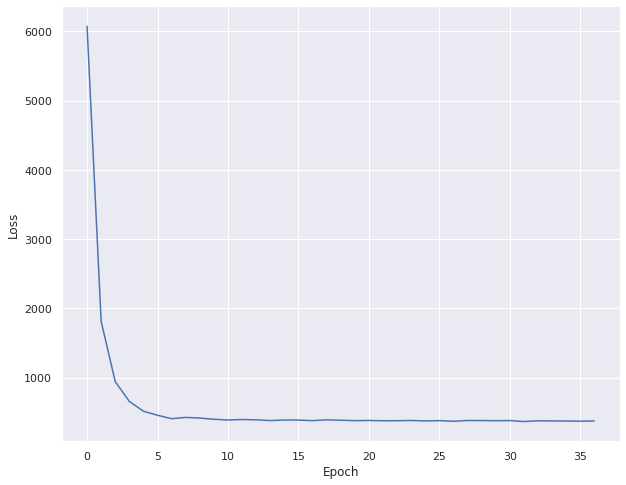

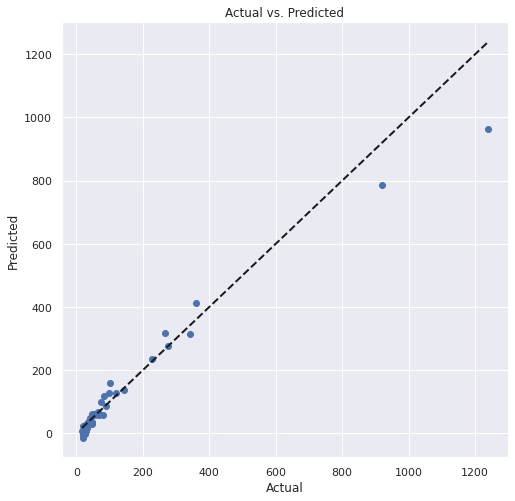

Wrote to file sucessfully.


In [41]:
with DisplayLossCurve(print_loss=True):
    model.fit(X_train_sc,y_train)
        
y_pred=model.predict(X_test_sc)

r2 = model.score(X_train_sc,y_train)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
evs = explained_variance_score(y_test, y_pred)

r2_lst.append(r2)

print()
print("LR: "+str(lr)+" Iterations= "+str(15000))
print("R2 Score: ", r2)
print("Mean absolute error: ", mae)
print("Root Mean squared error: ", rmse)
print("Explained Variance Score: ", evs)

file = open("Scikit_SGD_log.txt","a")
file.write("LR = " + str(lr) + ",max_iterations = " + str(itrs) + " R^2 = " + 
           str(r2) + ", MAE = " + str(mae) + ", RMSE = " + str(rmse) + 
           ",  Explained-Variance = " + str(evs) + " \n")
file.close()

plt.figure(figsize = (8,8))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--',lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

file = open("Scikit_SGD_log.txt","a")
file.write("LR = " + str(lr) + ", max_iterations = " + str(itrs) + ", R^2 = " + 
           str(r2) + ", MAE = " + str(mae) + ", RMSE = " + str(r2) + 
           ", Explained-Variance = " + str(evs) + " \n")
file.close()
print("Wrote to file sucessfully.")

In [42]:
#weights obtained
model.coef_

array([ 8.80955631, 13.13337567, 46.21912906, 13.49819145, -1.2626479 ,
        6.67382171, 65.88985961])

## We obtained a r2 score of 95.16% using scikit library which is less than that of our custom SGD regressor's score

## Now we can try altering iterations to observe how it affects r2 score like we did in part 1

=============== Loss Array ===============
[6071.038953 1821.46348   973.892193  664.369026  559.125936  482.120173
  429.556781  437.611557  415.324092  404.906168  400.036022  402.486903
  391.537424  394.709427  390.736637  390.237003  385.34474   388.301266
  381.873369  385.593655  379.811441  382.929266  375.63037   380.796415
  381.15503   378.901254  381.270332  380.773594]

For LR: 0.003, Iterations= 17500
R2 Score:  0.9569525128096922
Mean absolute error:  25.593928071452304
Root Mean squared error:  54.18557019096956
Explained Variance Score:  0.9476412193179591


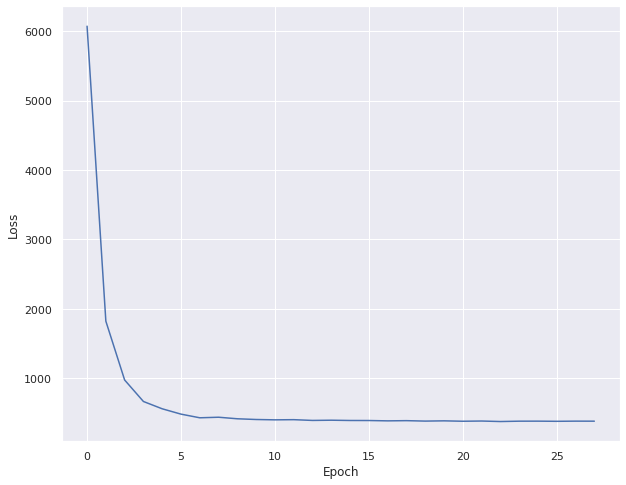

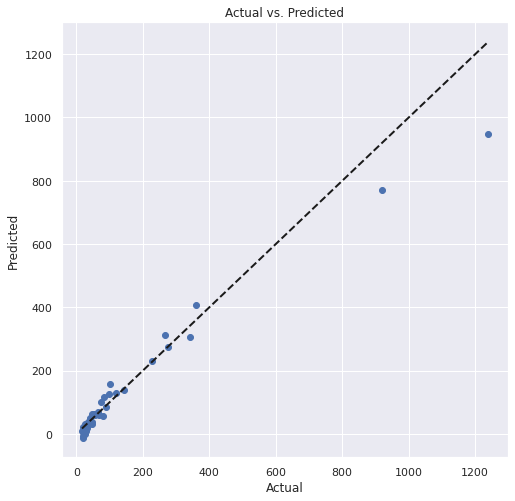

=============== Loss Array ===============
[5906.547144 1826.898242  976.253072  656.777009  524.13179   471.988561
  447.617112  412.162862  417.062677  406.351722  401.935151  397.854157
  372.587751  366.416922  366.942491  401.05991   392.835361  378.366674
  385.796903]

For LR: 0.003, Iterations= 20000
R2 Score:  0.9564715192706554
Mean absolute error:  25.993513216655533
Root Mean squared error:  56.834751041375036
Explained Variance Score:  0.9426841997438798


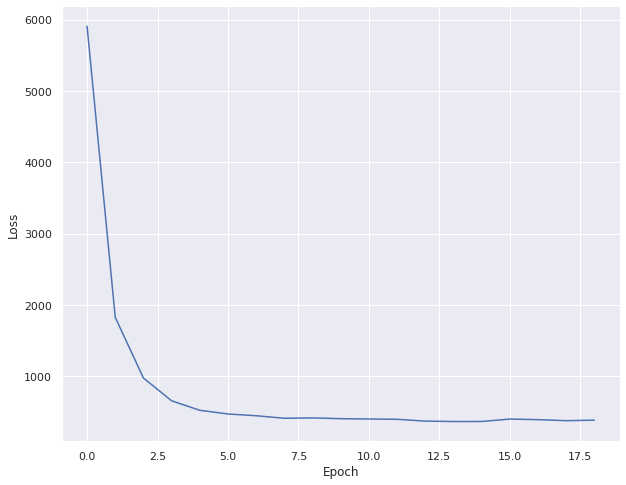

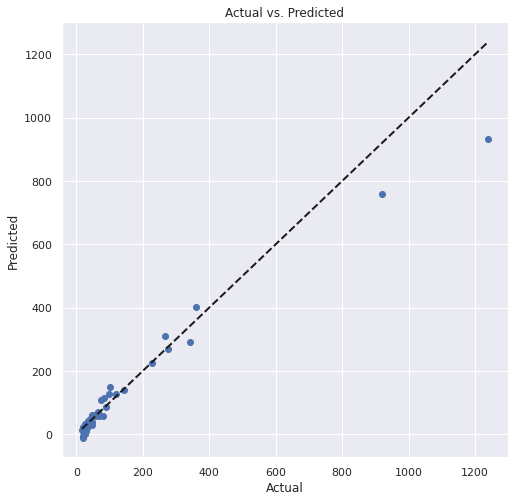

=============== Loss Array ===============
[6096.447596 1793.893198  925.862227  645.240837  510.88905   447.1667
  449.083601  417.887773  405.117625  406.122132  394.534524  392.78531
  393.183216  375.369149  383.105309  387.866191  379.203045  375.180851
  387.64674   364.966117  386.003181  384.360348  376.80902   384.318818
  368.103971]

For LR: 0.003, Iterations= 22500
R2 Score:  0.9564057837620915
Mean absolute error:  26.186848094822363
Root Mean squared error:  58.51796819209976
Explained Variance Score:  0.9392368141621991


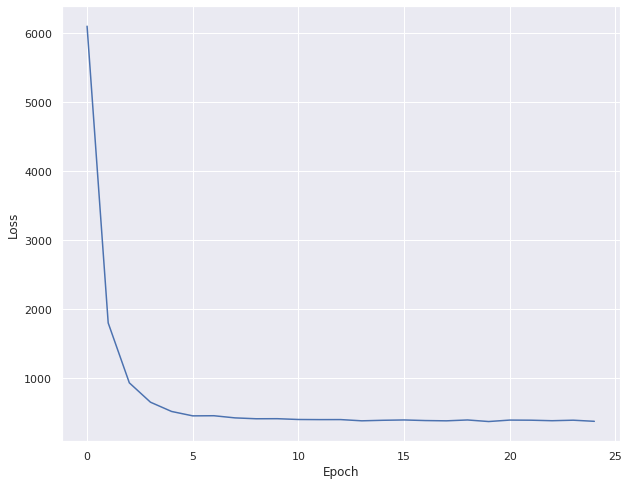

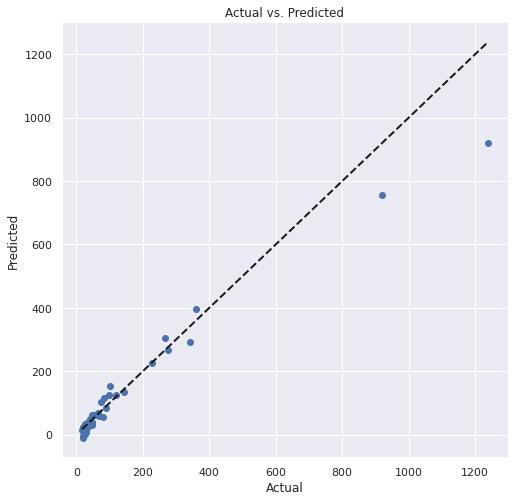

=============== Loss Array ===============
[6052.134523 1879.08436  1000.19496   675.163091  536.09849   472.562687
  429.830041  429.705088  402.545202  405.863005  396.354501  383.624499
  396.50898   393.883529  394.369029  393.786972  386.556191]

For LR: 0.003, Iterations= 25000
R2 Score:  0.9558656333959009
Mean absolute error:  25.684611303190415
Root Mean squared error:  52.607414218179954
Explained Variance Score:  0.9507696284538113


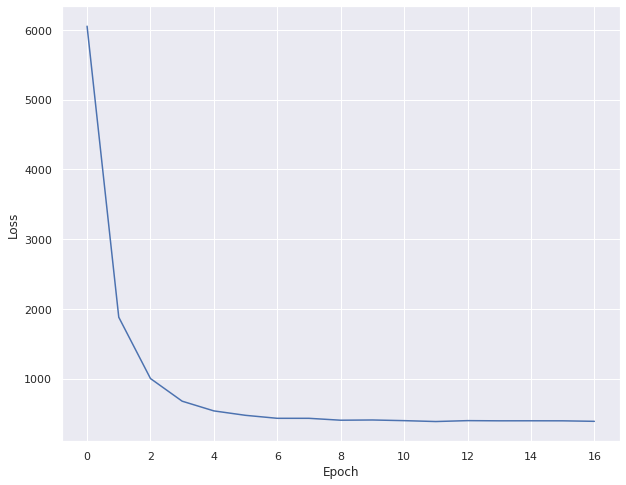

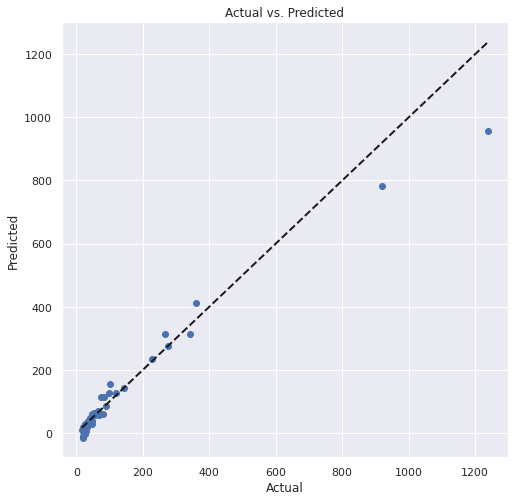

=============== Loss Array ===============
[5830.707788 1761.382614  986.562924  682.651564  542.682423  476.883997
  435.936778  426.66701   414.531863  411.479976  405.665293  399.532188
  389.445052  392.294487  394.601544  385.490266  390.479165  389.026362
  382.151276  388.630133  372.719143  387.928429  380.046137  379.208342
  383.043095  377.32672 ]

For LR: 0.003, Iterations= 27500
R2 Score:  0.955032806788986
Mean absolute error:  25.629971705641825
Root Mean squared error:  50.220674721027855
Explained Variance Score:  0.954925957154724


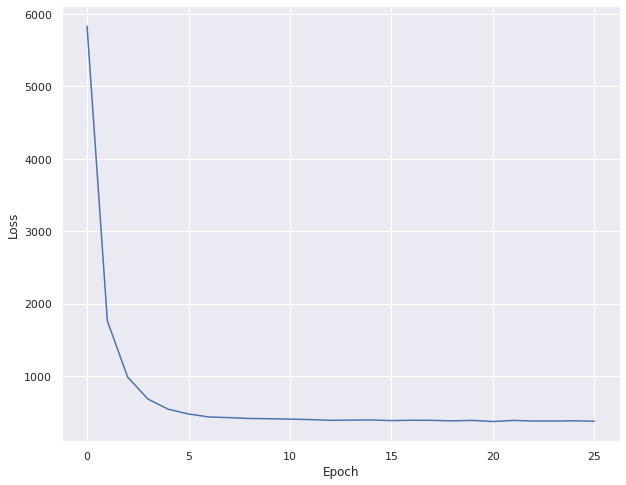

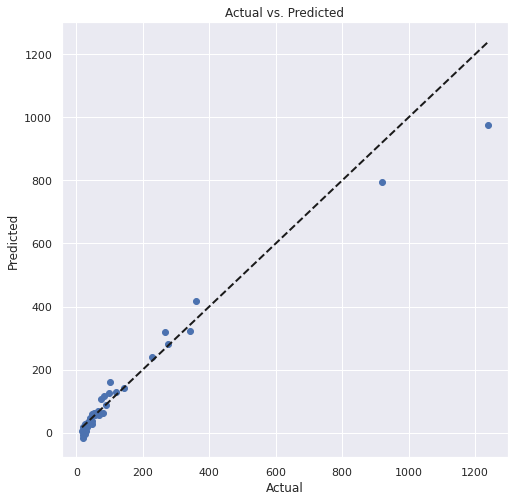

=============== Loss Array ===============
[6204.046307 1807.413653  996.250912  645.939958  459.477398  478.429006
  440.856977  426.138591  408.815937  403.47205   391.002035  395.347381
  395.105999  386.832274  381.584367  390.287382  368.203463  395.203078
  373.096769  388.051086  384.656754  370.029701]

For LR: 0.003, Iterations= 30000
R2 Score:  0.9552505530824827
Mean absolute error:  25.794163019174274
Root Mean squared error:  50.76103845609937
Explained Variance Score:  0.9541893934235873


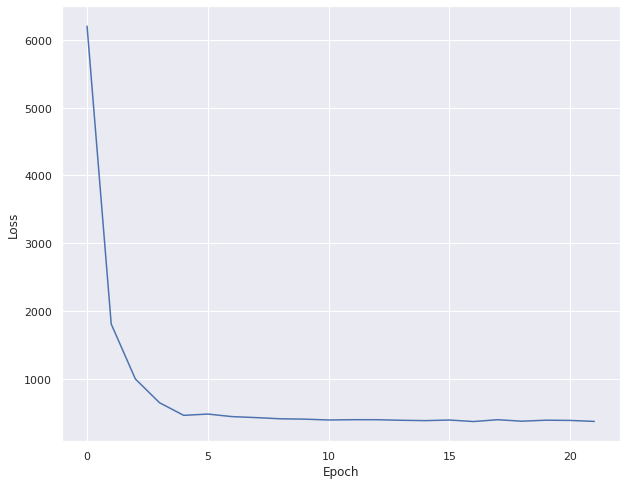

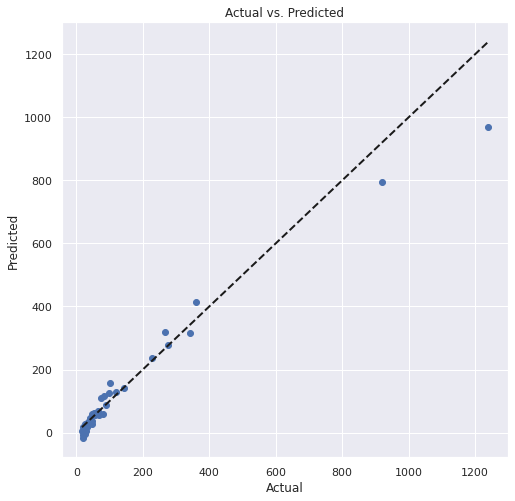

=============== Loss Array ===============
[5907.299189 1866.590586 1014.465163  661.908058  530.383385  470.713947
  433.128972  423.363264  415.548895  407.70089   392.888741  380.466107
  400.851326  392.307717  390.866922  388.807004  374.630622  381.517537
  385.724192  383.886231  382.382666  378.015864]

For LR: 0.003, Iterations= 32500
R2 Score:  0.9566990363408159
Mean absolute error:  25.636142042489062
Root Mean squared error:  53.82061946605013
Explained Variance Score:  0.9484475696761622


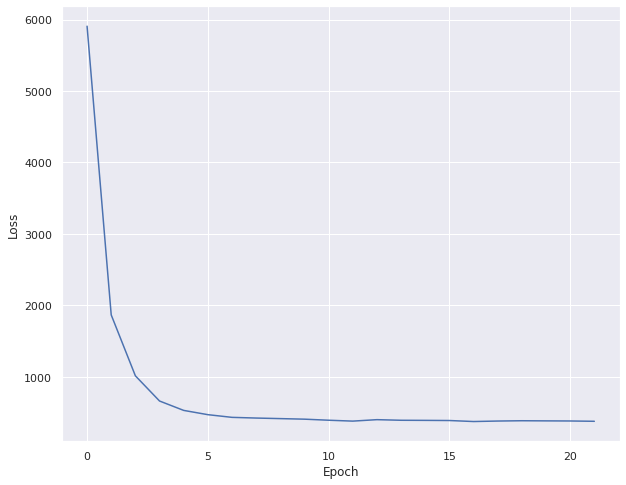

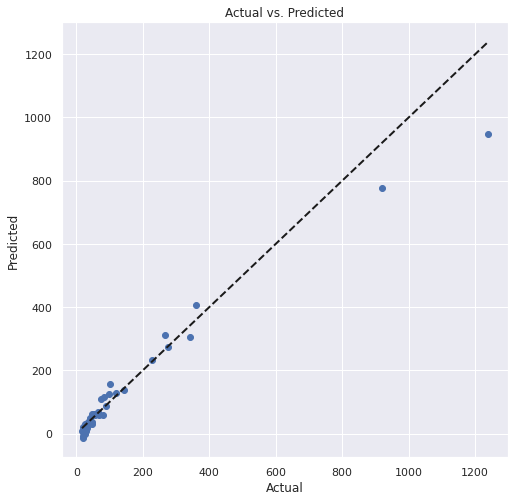

=============== Loss Array ===============
[6111.760357 1834.067037  972.325188  668.85642   527.17214   466.812454
  413.372797  432.490988  419.821175  408.236906  398.427521  376.929799
  393.599281  385.084264  397.565561  386.014441  386.088415]

For LR: 0.003, Iterations= 35000
R2 Score:  0.9542250437494495
Mean absolute error:  26.053640569434826
Root Mean squared error:  49.93717463993683
Explained Variance Score:  0.955671697044926


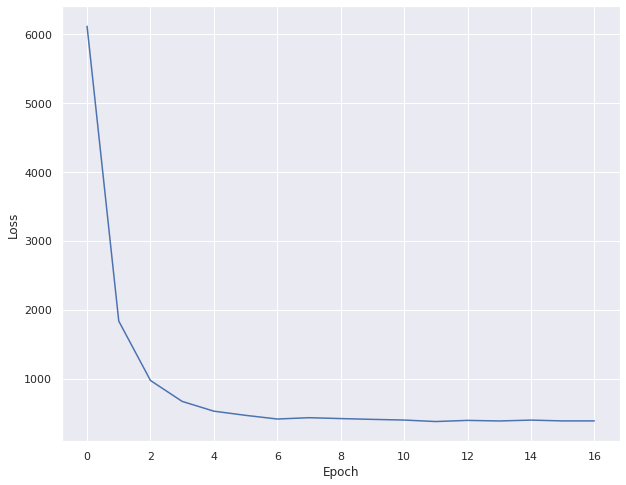

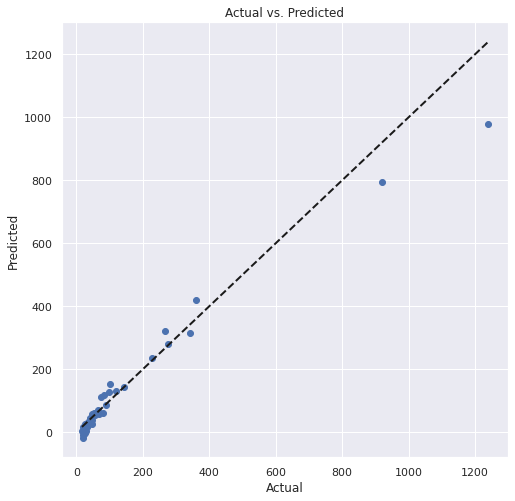

=============== Loss Array ===============
[6476.577702 1805.52203   930.310708  638.233898  495.32372   458.317041
  429.650098  408.76382   405.127087  395.742094  389.95153   400.908282
  394.536975  387.016521  389.288496  384.795717  389.065059  382.587836
  370.698213  383.17613   373.929683  386.340009  381.179205  363.347404
  386.931132  372.233529  381.647778  379.753876  369.400992]

For LR: 0.003, Iterations= 37500
R2 Score:  0.9570331556178285
Mean absolute error:  25.834645247715542
Root Mean squared error:  55.14027004551649
Explained Variance Score:  0.9460272566314591


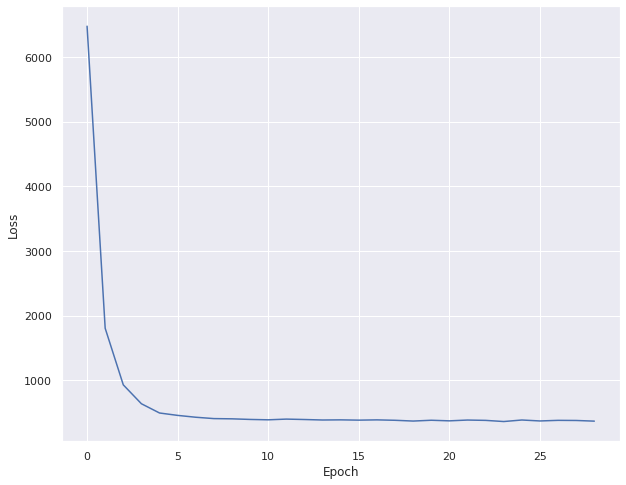

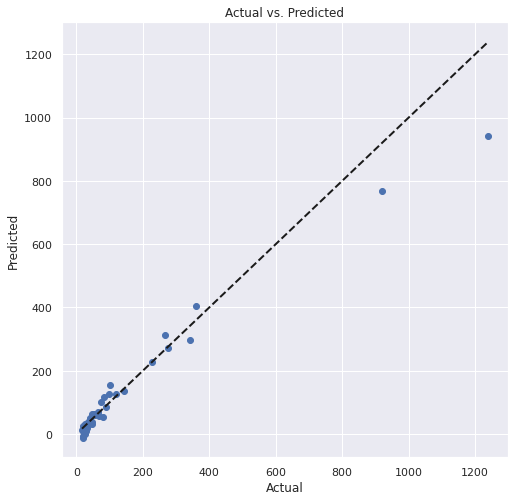

=============== Loss Array ===============
[6195.382774 1774.837708  977.021793  642.892604  516.470932  459.118306
  424.089397  417.104461  412.278844  403.832088  396.342753  388.106257
  392.800053  378.092448  394.414422  394.332958  384.050477  381.398468
  378.419033]

For LR: 0.003, Iterations= 40000
R2 Score:  0.9566647235221852
Mean absolute error:  25.909959523625055
Root Mean squared error:  55.9377796991934
Explained Variance Score:  0.9445006623158345


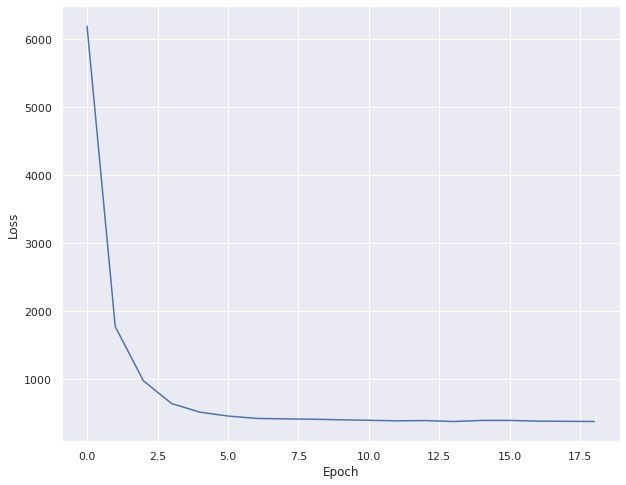

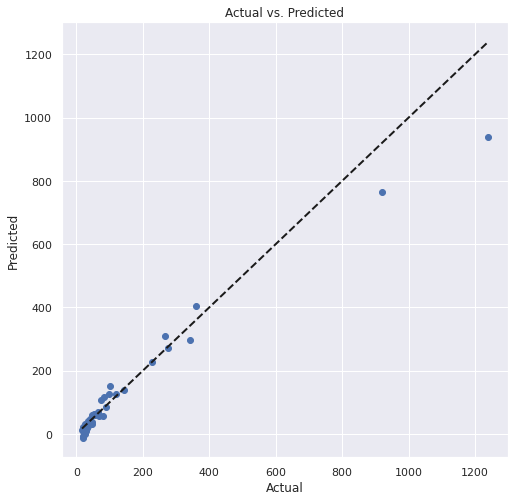

=============== Loss Array ===============
[5931.948851 1845.411816  977.159554  643.605537  540.156043  469.747342
  428.68818   417.530246  408.9001    409.967692  400.856153  394.931902
  397.661046  386.079199  390.098957  388.776689  391.780314  373.786714
  380.310676  381.970939  380.806399  378.914404  381.818643]

For LR: 0.003, Iterations= 42500
R2 Score:  0.9568491101605828
Mean absolute error:  25.860204125493688
Root Mean squared error:  55.64029768059053
Explained Variance Score:  0.9449354691593166


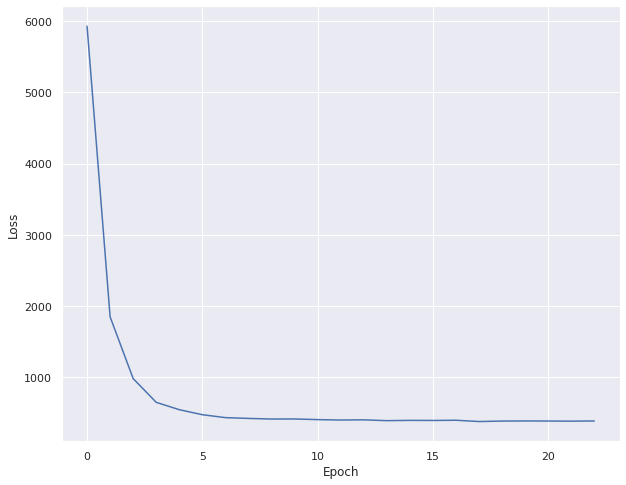

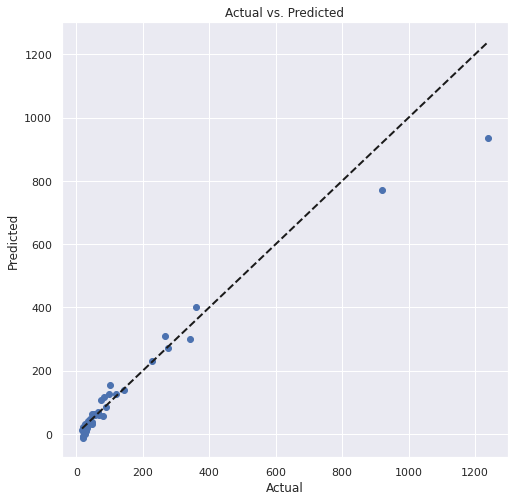

=============== Loss Array ===============
[5747.831681 1822.128942 1012.042009  680.195172  530.261813  474.657204
  451.248602  421.104639  424.55032   405.514453  406.387654  395.74894
  393.49897   393.582813  393.722083  387.257962  373.883022  395.140613
  388.265062  380.852024  385.449055  373.797278  373.515822  384.382492
  381.300611  375.863974  378.559833  384.2538  ]

For LR: 0.003, Iterations= 45000
R2 Score:  0.9567899977652793
Mean absolute error:  25.655154853845044
Root Mean squared error:  53.71324042685213
Explained Variance Score:  0.9487351288265826


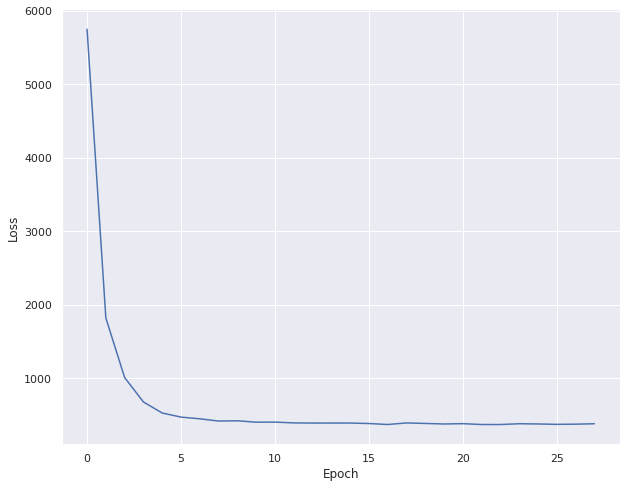

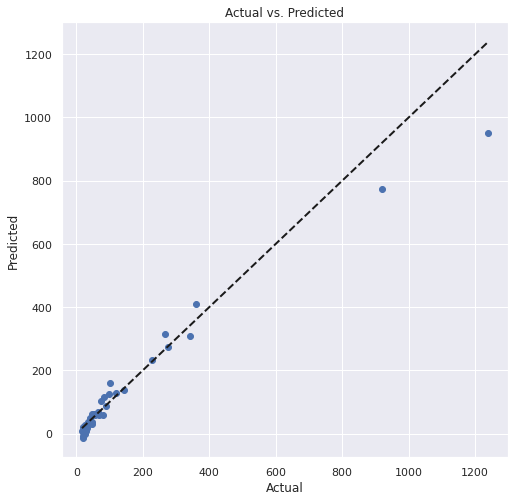

=============== Loss Array ===============
[5645.207909 1846.200446 1014.940983  681.437753  524.634897  498.519746
  447.692104  425.900404  400.155864  410.144059  405.674843  396.981665
  394.881354  392.787651  385.909442  389.79229   382.666516  385.088456
  376.459122  390.379087  378.570756  379.207998  381.134206  388.452244]

For LR: 0.003, Iterations= 47500
R2 Score:  0.9568829099720658
Mean absolute error:  25.720574961774712
Root Mean squared error:  54.52494263400941
Explained Variance Score:  0.947204113484203


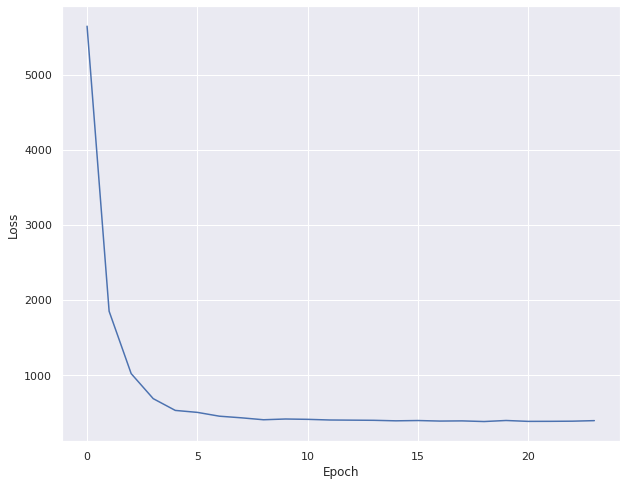

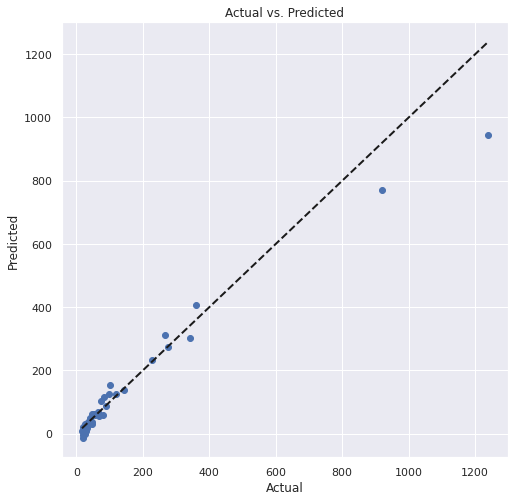

=============== Loss Array ===============
[5800.290095 1837.393835  999.105939  625.432006  534.837653  477.529847
  447.712456  427.209632  415.696279  407.798011  401.250287  391.814045
  396.699091  399.994286  388.094605  389.368516  375.399397  385.706252
  387.717773  384.510674  376.798202  379.419198]

For LR: 0.003, Iterations= 50000
R2 Score:  0.9562520712689068
Mean absolute error:  26.1479768005052
Root Mean squared error:  58.4076909011371
Explained Variance Score:  0.9393890313013623


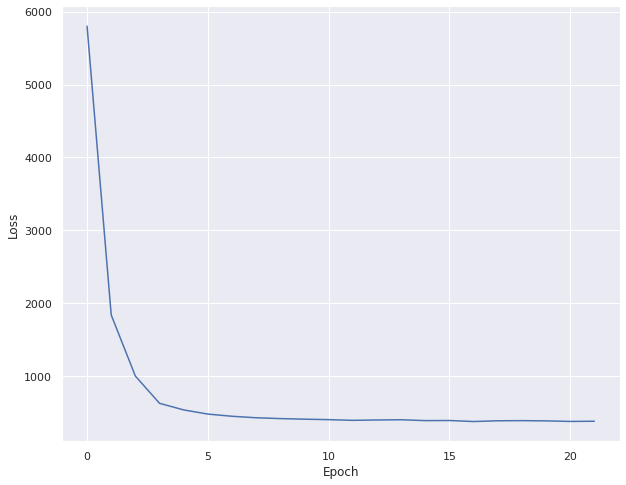

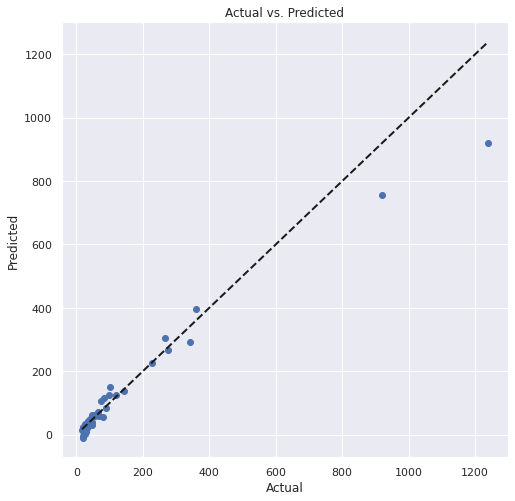

In [43]:
itrs = 17500
lr =0.003
r2_lst = []

while itrs <= 50000:
    model=SGDRegressor(learning_rate='constant', eta0=lr, max_iter=itrs, verbose=1)

    with DisplayLossCurve(print_loss=True):
        model.fit(X_train_sc,y_train)

    y_pred=model.predict(X_test_sc)

    r2 = model.score(X_train_sc,y_train)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    evs = explained_variance_score(y_test, y_pred)

    r2_lst.append(r2)

    print()
    print("For LR: "+str(lr)+", Iterations= "+str(itrs))
    print("======================================")
    print("R2 Score: ", r2)
    print("Mean absolute error: ", mae)
    print("Root Mean squared error: ", rmse)
    print("Explained Variance Score: ", evs)

    file = open("Scikit_SGD_log.txt","a")
    file.write("LR = " + str(lr) + ",max_iterations = " + str(itrs) + " R^2 = " 
               + str(r2) + ", MAE = " + str(mae) + ", RMSE = " + str(rmse) + 
               ",  Explained-Variance = " + str(evs) + " \n")
    file.close()

    plt.figure(figsize = (8,8))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--',lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted')
    plt.show()
    
    itrs+=2500

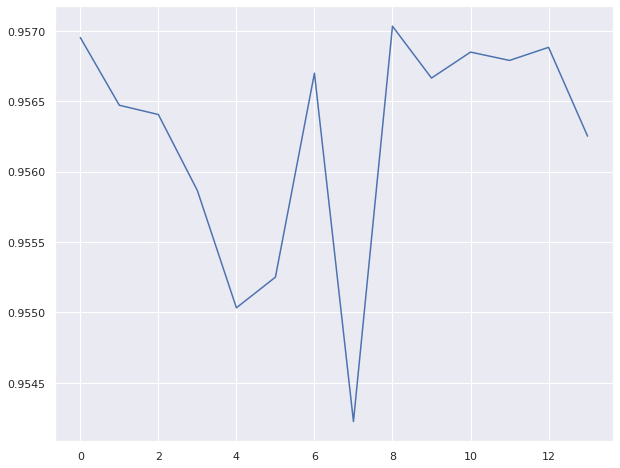

In [44]:
plt.plot(r2_lst)

## R2 score fluctuates as seen from the above plot

## Now we try altering learning rate while keeping iterations same

=============== Loss Array ===============
[6015.146368 1854.920047 1005.66227   680.52103   516.332742  470.87379
  429.795186  417.463099  403.323333  404.499752  396.304011  388.507066
  392.880095  388.668367  371.00475   394.635587  371.99243   392.242392
  384.02059   382.682865]

For LR: 0.003, Iterations= 15000
R2 Score:  0.9566408256712335
Mean absolute error:  25.697409320563235
Root Mean squared error:  54.13518275609155
Explained Variance Score:  0.9478915269635809


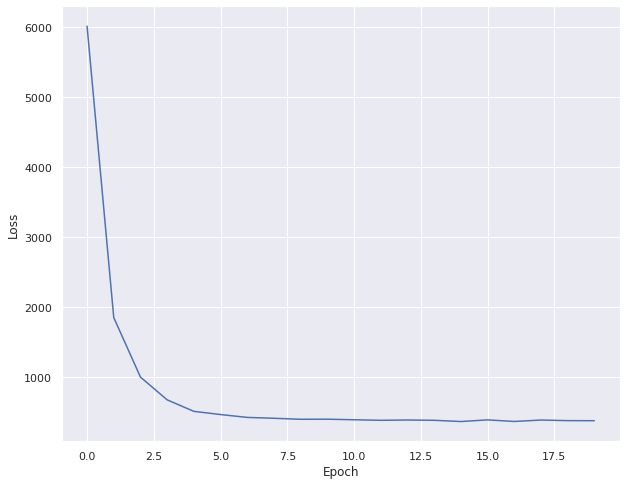

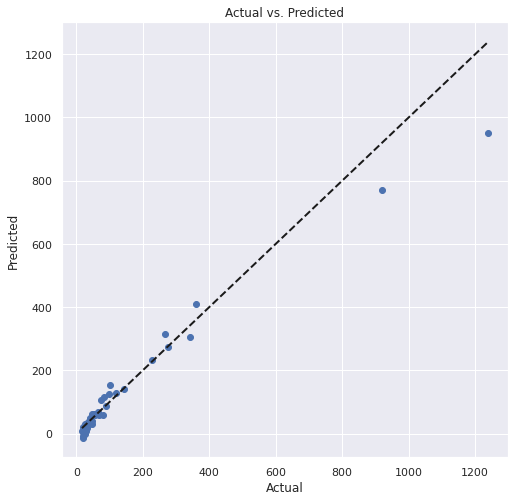

=============== Loss Array ===============
[7980.253836 3466.44824  2092.961973 1441.982482 1076.956843  836.690396
  683.201     582.687852  520.814663  474.05785   454.786814  440.190777
  424.445419  410.864052  402.683016  399.44356   386.715796  393.249806
  381.369186  387.279186  383.102059  376.41361   379.660507  379.521856
  376.762057  368.909093  368.452196  376.783579  376.634316  370.026732
  373.02014   369.639408]

For LR: 0.0015, Iterations= 15000
R2 Score:  0.9562639207774449
Mean absolute error:  25.77364799237426
Root Mean squared error:  56.027133351783746
Explained Variance Score:  0.9442619610234873


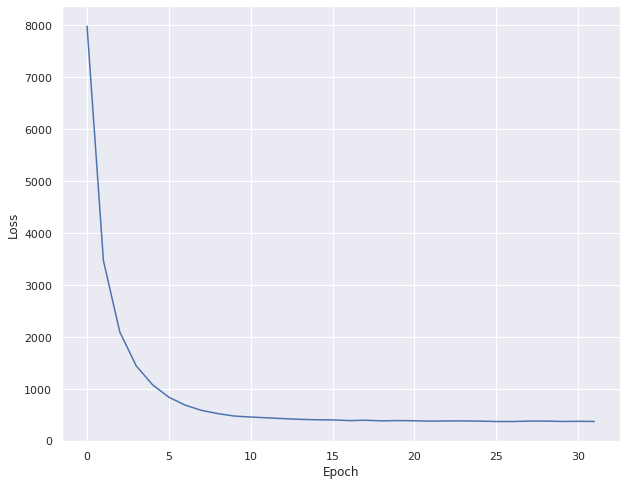

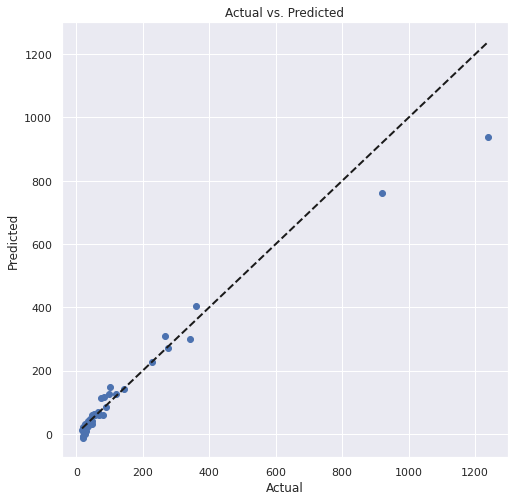

=============== Loss Array ===============
[9451.296956 5570.606424 3811.658445 2861.659506 2273.808451 1853.491014
 1541.16412  1302.985703 1116.741081  975.826888  857.438271  767.516946
  695.69767   637.83999   591.727992  549.301174  525.265444  500.117404
  480.102181  462.731169  449.932203  436.305751  428.833063  421.588054
  414.763695  409.37831   404.065292  399.913127  396.808468  393.343137
  390.171617  386.187598  386.449187  383.778331  381.782235  379.83988
  379.163404  377.197536  377.037522  375.156403  373.251189  373.657398
  371.555454  371.227435  370.978065  370.039332  369.165123  368.197961
  368.033575  367.890565  367.367457  366.728871  366.127781  364.956217
  364.985444  363.861655  364.359898  363.530161  363.327944  361.447514
  362.964871  361.74748   362.104168  359.908239  361.726581  360.622588
  360.60792   360.557518  360.014851]

For LR: 0.00075, Iterations= 15000
R2 Score:  0.9563311566052329
Mean absolute error:  25.773529889205754
Root Mean 

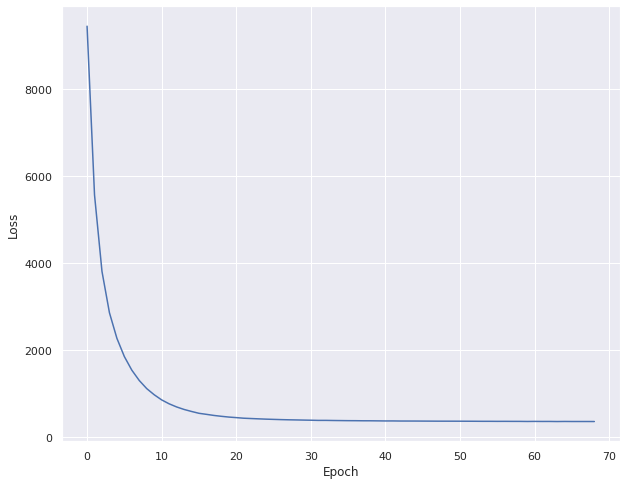

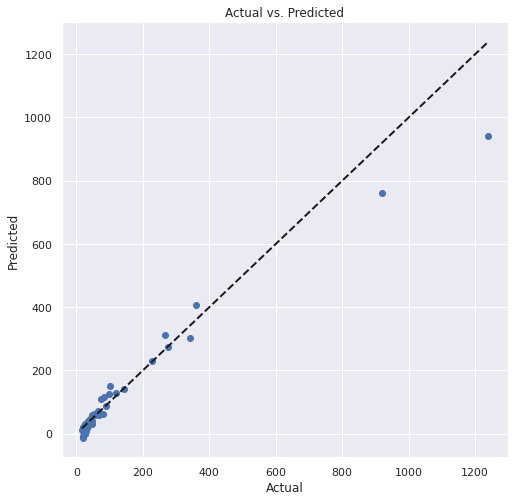

=============== Loss Array ===============
[10726.133807  7957.040124  6146.560817  4923.714031  4076.35851
  3456.396651  2993.445406  2634.31445   2346.482136  2110.031356
  1907.576369  1734.207063  1584.064634  1452.616766  1337.057452
  1234.492739  1144.422574  1064.284742   992.886575   928.825883
   872.393306   822.060684   777.355525   737.269891   701.436561
   669.490178   641.226095   615.915955   593.161166   572.088837
   553.410774   536.970427   522.090016   509.111926   496.857578
   486.234702   476.275296   467.210809   459.465176   451.929242
   445.422169   439.446743   434.042084   429.085355   424.528674
   420.488949   416.442961   413.173855   410.027335   406.969978
   403.727552   401.596792   399.592305   397.011144   395.478526
   393.678167   391.899986   390.019922   388.622683   387.310017
   385.721779   384.762138   383.52493    382.141382   381.443719
   380.332708   379.345622   378.642814   377.624823   376.892059
   376.223929   375.414479   374.7

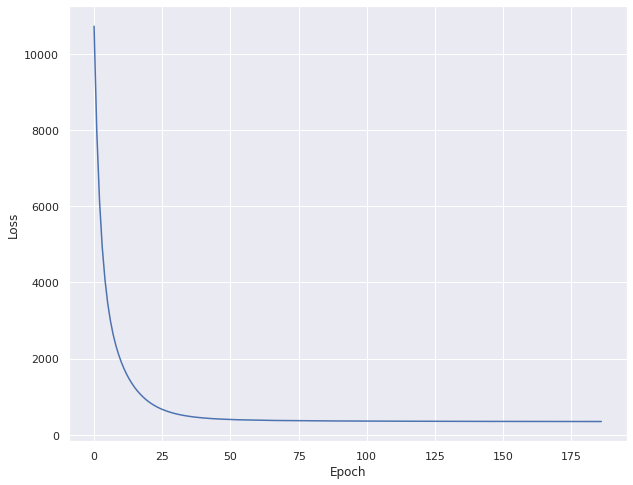

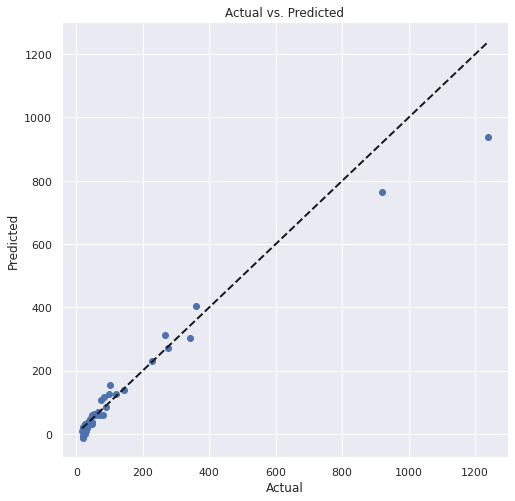

=============== Loss Array ===============
[11442.417137  9762.735825  8420.868082  7339.085987  6458.489765
  5736.585365  5141.526216  4646.250051  4231.039617  3880.770635
  3579.945004  3318.963756  3092.520799  2893.410457  2716.365169
  2557.393524  2412.925176  2282.002887  2161.845874  2051.924423
  1951.493929  1857.838509  1770.943002  1690.198903  1614.765312
  1544.339335  1478.712088  1417.026728  1359.403524  1304.960293
  1253.983114  1205.98973   1160.911222  1118.301702  1078.376113
  1040.749013  1005.149787   971.873722   940.268342   910.420536
   882.2203     855.645778   830.721726   806.719645   784.708182
   763.51225    743.584725   724.780394   706.948421   690.133568
   674.05697    659.110309   644.97103    631.30099    618.625829
   606.60685    595.235994   584.369337   574.176741   564.49645
   555.336276   546.636501   538.360754   530.308686   523.052177
   516.012198   509.438663   502.900277   497.075068   491.372966
   485.93419    480.84149    475.8

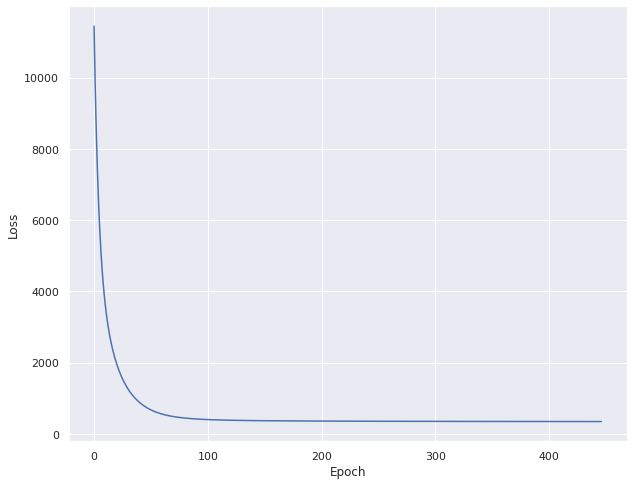

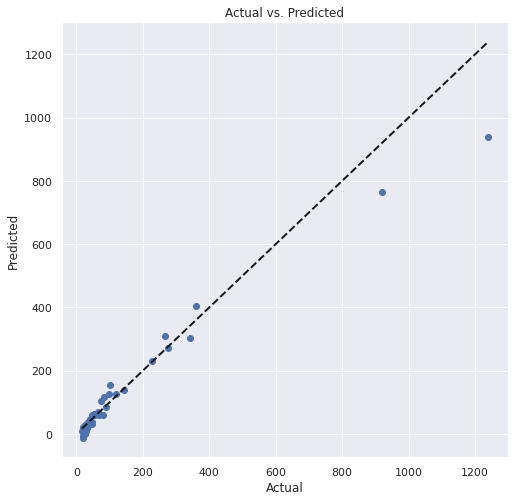

In [45]:
lr = 0.003
itrs=15000
r2_lst = []

while lr >= 0.0001:
    model=SGDRegressor(learning_rate='constant', eta0=lr, max_iter=itrs, verbose=1)

    with DisplayLossCurve(print_loss=True):
        model.fit(X_train_sc,y_train)

    y_pred=model.predict(X_test_sc)

    r2 = model.score(X_train_sc,y_train)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    evs = explained_variance_score(y_test, y_pred)

    r2_lst.append(r2)

    print()
    print("For LR: "+str(lr)+", Iterations= "+str(itrs))
    print("======================================")
    print("R2 Score: ", r2)
    print("Mean absolute error: ", mae)
    print("Root Mean squared error: ", rmse)
    print("Explained Variance Score: ", evs)

    file = open("Scikit_SGD_log.txt","a")
    file.write("LR = " + str(lr) + ",max_iterations = " + str(itrs) + " R^2 = "
    + str(r2) + ", MAE = " + str(mae) + ", RMSE = " + str(rmse) + 
    ",  Explained-Variance = " + str(evs) + " \n")
    file.close()

    plt.figure(figsize = (8,8))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--',lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted')
    plt.show()
    
    r2_lst.append(np.around(r2,2))
    lr/=2

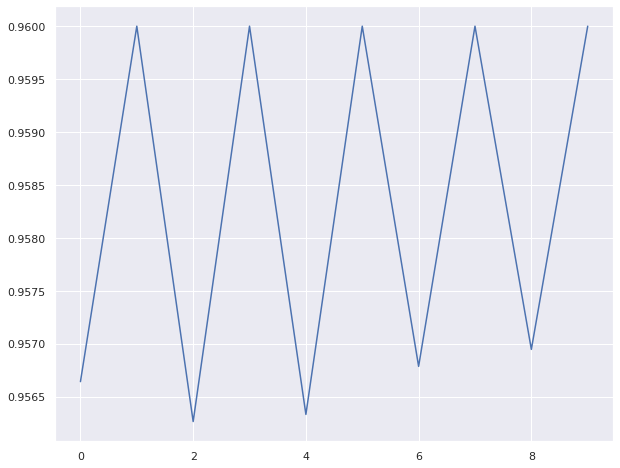

In [46]:
plt.plot(r2_lst)

## This does not improves much

## We can try to improve the above plot by increasing iterations say 150000

=============== Loss Array ===============
[6101.127778 1920.397509  986.023617  668.986477  536.153178  463.047835
  437.70771   417.881743  397.510388  374.673511  415.276391  397.470233
  397.993757  374.03565   394.157473  367.410717  390.748602  385.170346
  379.807997  381.814094  386.132441]

For LR: 0.003, Iterations= 150000
R2 Score:  0.9567803684647529
Mean absolute error:  25.81688007988116
Root Mean squared error:  54.965241828486015
Explained Variance Score:  0.9463760450717472


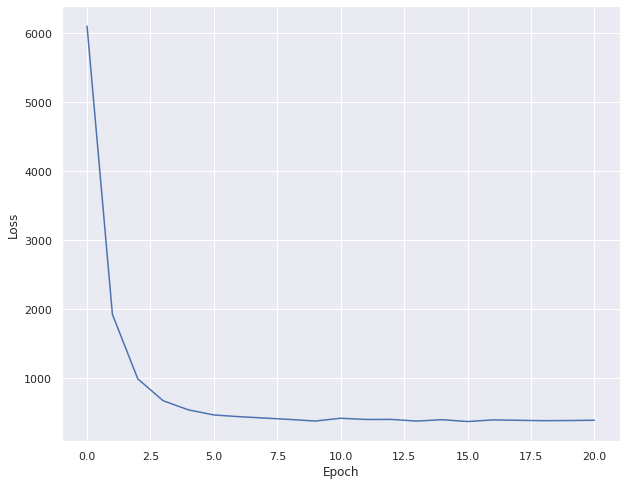

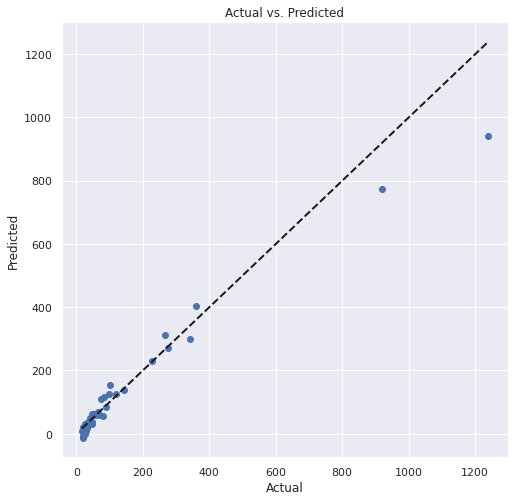

=============== Loss Array ===============
[7602.141366 3352.955513 2085.6795   1477.466611 1083.903796  841.726795
  679.585864  586.768109  529.124737  486.246253  455.977275  436.403824
  422.27966   414.368216  404.749089  401.3991    395.994507  392.371342
  389.828976  386.531204  384.017599  381.377076  379.960215  379.019211
  375.898018  376.447234  374.391748  374.57004   373.504381  372.578393
  368.275868  368.244992  370.937849  367.273792  369.270062  369.008374
  367.603578  364.018306  367.619334  367.22897   365.440626  366.521477
  365.647689]

For LR: 0.0015, Iterations= 150000
R2 Score:  0.9567160799377619
Mean absolute error:  25.73949250215789
Root Mean squared error:  55.00590281397207
Explained Variance Score:  0.9462444504604843


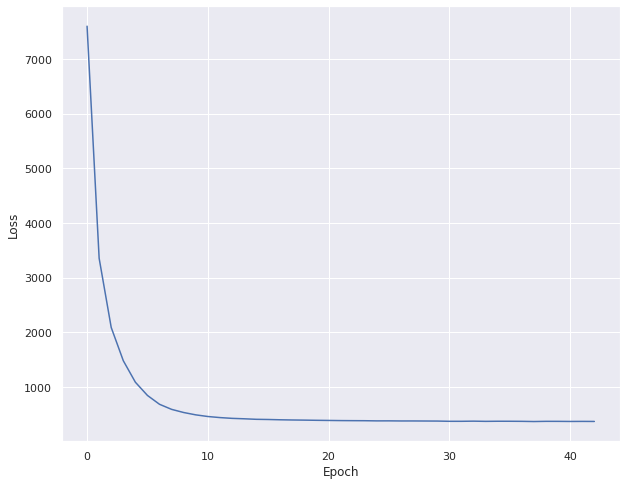

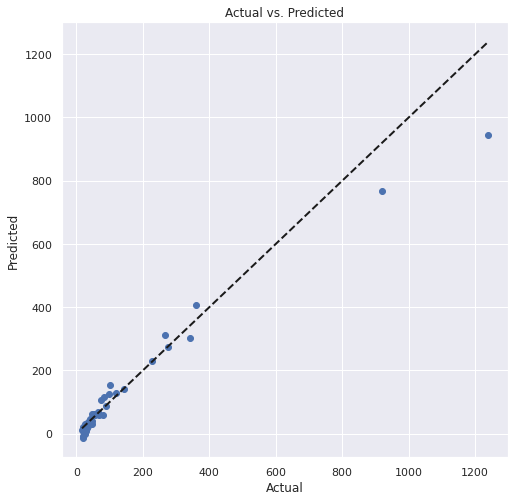

=============== Loss Array ===============
[9478.626259 5599.557043 3794.836287 2837.354771 2248.555956 1842.961546
 1543.039038 1304.435353 1121.851984  976.595814  858.157711  772.224106
  696.706397  639.663398  591.459517  555.034794  523.846702  499.663367
  479.335427  462.806947  447.656179  438.730334  428.436091  420.950289
  414.501633  407.163705  404.56903   399.110141  396.634481  393.66823
  390.767787  387.454035  385.955385  381.717237  382.521471  380.224055
  379.307286  377.970689  376.723749  376.090926  373.537877  373.141855
  372.330289  372.158612  370.530918  370.28877   368.114548  368.626735
  368.2984    367.572427  367.22201   366.032784  365.355059  365.448591
  364.312437  365.057487  363.993187  363.120054  362.403925  363.121994
  361.206704  362.667463  361.946252  360.930285  361.570644  361.05835
  360.391412  358.858677  359.661491  359.933114  359.147885  359.267063
  358.352207  358.785916  358.754228  358.410486  358.169107  356.464461
  358.1611

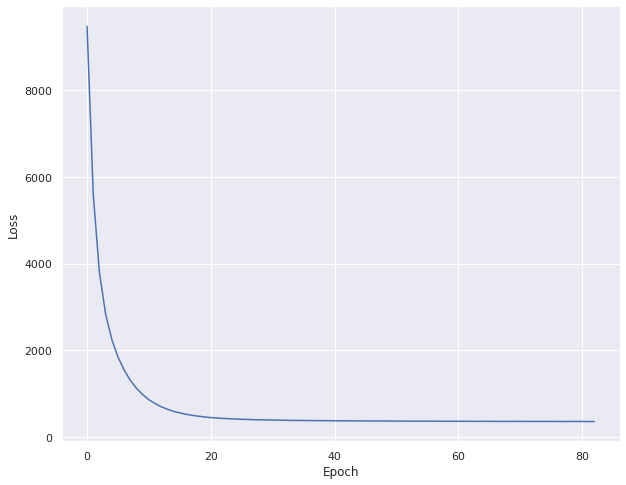

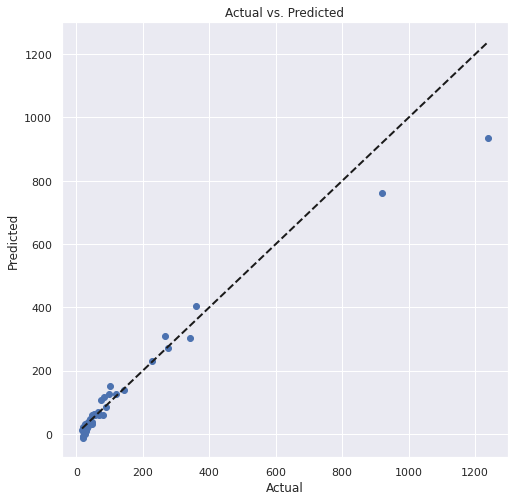

=============== Loss Array ===============
[10729.434839  7952.853512  6142.11981   4932.262106  4088.387702
  3478.295707  3013.509436  2649.765813  2356.581786  2115.443041
  1913.376857  1739.151191  1587.574691  1455.547172  1338.629532
  1235.135264  1144.208403  1063.945854   992.409866   928.549775
   872.584273   822.214542   776.594537   737.569914   701.873307
   669.214656   641.016059   615.231883   592.049007   571.735391
   554.107965   537.416102   522.382763   508.98459    496.936999
   485.997498   475.854824   467.613759   459.237388   451.969408
   445.636898   439.384346   433.959378   429.084744   424.382883
   420.05543    416.566294   413.17319    409.468894   406.2405
   404.337035   401.805348   399.405735   397.366362   395.094836
   393.639196   391.606731   389.875532   388.761232   387.369273
   385.860842   384.741778   383.526382   382.479335   381.424142
   379.730328   379.590444   378.709502   377.837387   376.967868
   376.23574    375.338771   374.77

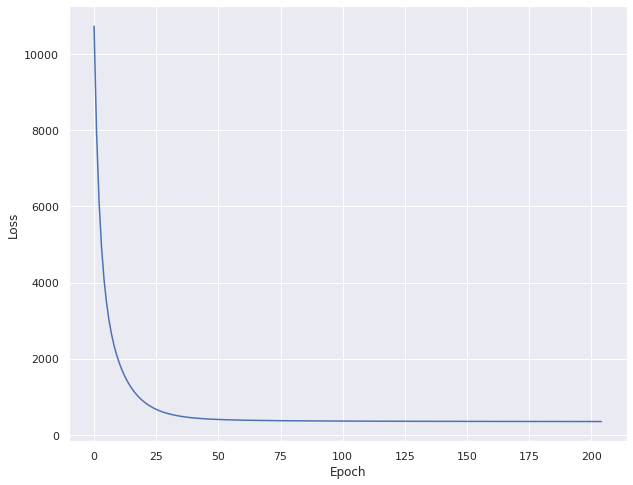

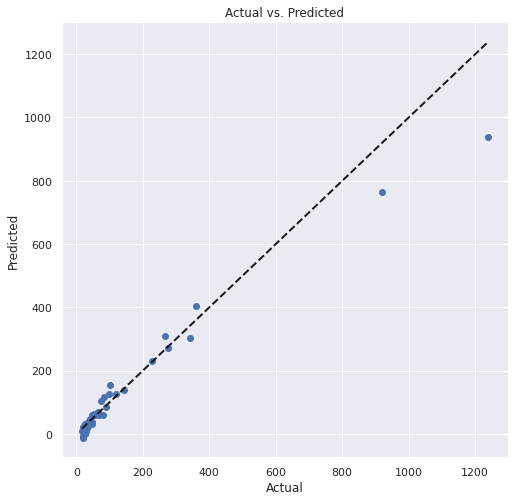

=============== Loss Array ===============
[11444.99693   9768.871772  8427.487031  7341.793629  6458.26324
  5738.423387  5143.589745  4650.118154  4236.664048  3885.537172
  3584.136533  3323.239894  3096.838352  2895.226956  2715.86521
  2555.274513  2411.098325  2280.339403  2160.647667  2050.531294
  1949.25845   1855.844519  1769.145925  1688.617551  1613.366358
  1543.122786  1477.500848  1415.954606  1358.430682  1304.257033
  1253.41576   1205.304943  1160.250812  1118.006689  1078.022054
  1040.229672  1004.797045   971.25722    939.871934   910.051939
   881.914702   855.345344   830.277642   806.612883   784.277103
   762.999434   743.054499   724.350796   706.593519   689.726725
   673.807736   658.790529   644.575723   631.108796   618.348304
   606.253794   594.80719    583.930648   573.815119   564.164966
   555.017562   546.255836   537.842361   530.306272   522.878243
   515.934809   509.108968   502.820632   496.917995   490.800061
   485.805795   480.496982   475.78

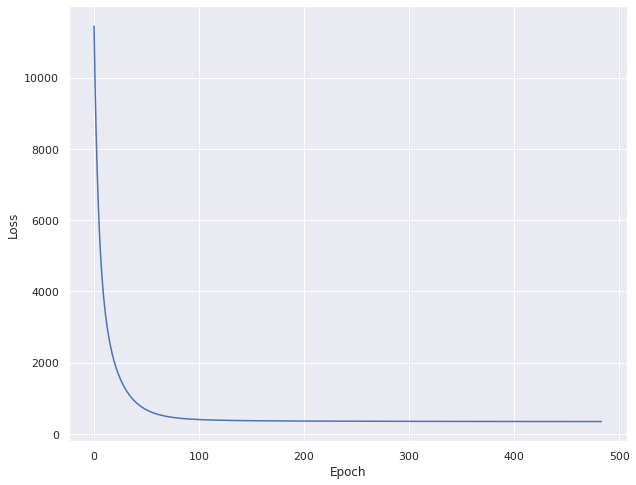

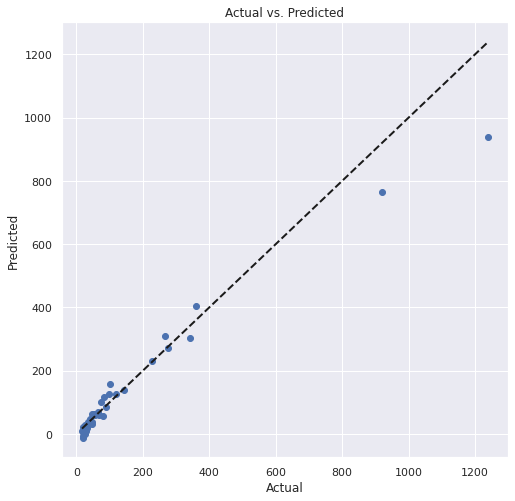

In [47]:
lr = 0.003
itrs = 150000
r2_lst = []

while lr >= 0.0001:
    model=SGDRegressor(learning_rate='constant', eta0=lr, max_iter=itrs, verbose=1)

    with DisplayLossCurve(print_loss=True):
        model.fit(X_train_sc,y_train)

    y_pred=model.predict(X_test_sc)

    r2 = model.score(X_train_sc,y_train)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    evs = explained_variance_score(y_test, y_pred)

    r2_lst.append(r2)

    print()
    print("For LR: "+str(lr)+", Iterations= "+str(itrs))
    print("======================================")
    print("R2 Score: ", r2)
    print("Mean absolute error: ", mae)
    print("Root Mean squared error: ", rmse)
    print("Explained Variance Score: ", evs)

    file = open("Scikit_SGD_log.txt","a")
    file.write("LR = " + str(lr) + ",max_iterations = " + str(itrs) + 
               " R^2 = " + str(r2) + ", MAE = " + str(mae) + ", RMSE = " 
               + str(rmse) + ",  Explained-Variance = " + str(evs) + " \n")
    file.close()

    plt.figure(figsize = (8,8))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--',lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted')
    plt.show()
    
    r2_lst.append(r2)
    lr/=2

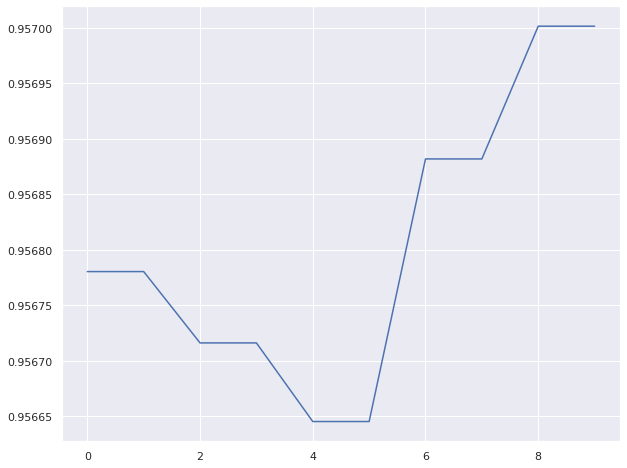

In [48]:
plt.plot(r2_lst)

## We can observe this also doesn't help much

# Final Conclusion:
## Hence we conclude that our custom SGD regressor works better than Scikit's SGD regressor